### Load necessary libraries and prepare dataset

In [ ]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from datasets import load_dataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim import corpora, models, similarities, downloader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import numpy as np
np.random.seed(42)

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
transformation = lambda s: " ".join([lemmatizer.lemmatize(word) for word in re.sub('[\W\d]+', ' ', s).lower().split() if word not in stop_words])

# read /fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz
dataset = pd.read_csv("/fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz", compression="gzip")
dataset['abstract_org'] = dataset['abstract'] #backup
dataset['abstract'] = dataset['abstract'].apply(transformation)

[nltk_data] Downloading package wordnet to /home/sushant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sushant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Train custom word embedding model

In [ ]:
print("Available pre-trained corpora:", list(downloader.info()['corpora'].keys()))
# print([folder for folder in os.listdir('/fp/projects01/ec30/corpora')])

Available pre-trained corpora: ['semeval-2016-2017-task3-subtaskBC', 'semeval-2016-2017-task3-subtaskA-unannotated', 'patent-2017', 'quora-duplicate-questions', 'wiki-english-20171001', 'text8', 'fake-news', '20-newsgroups', '__testing_matrix-synopsis', '__testing_multipart-matrix-synopsis']


In [ ]:
# dataset_arxiv_hf_df = pd.DataFrame({'abstract': load_dataset("gfissore/arxiv-abstracts-2021")["train"]['abstract']})
# dataset_arxiv_hf_df['abstract'] = dataset_arxiv_hf_df['abstract'].apply(transformation)
# concatenated_df = pd.concat([pd.DataFrame({'abstract': dataset['abstract'].values}), dataset_arxiv_hf_df], ignore_index=True)
# concatenated_df_ = concatenated_df.dropna(subset=['abstract'])
# concatenated_df_.to_csv('corpus.csv', index=False)
# corpus_to_train = concatenated_df['abstract']

# corpus_to_train = pd.read_csv('corpus.csv').dropna()['abstract']

In [ ]:
# #number of abstracts in corpus_to_train : 2,079,484, from dataset_arxiv_hf: 2M  from our dataset['abstract']: 80K
# print("Total number of tokens:", corpus_to_train.apply(lambda x: len(x.split())).sum()) # 179,355,863
# print("Number of unique tokens:", len(set(" ".join(corpus_to_train).split()))) # 471,322

In [ ]:
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch > 0:
            current_loss = loss - self.prev_loss
            self.losses.append(current_loss)
            print(f'Epoch {self.epoch}: Loss: {current_loss}')
        else:
            self.losses.append(loss)
            print(f'Epoch {self.epoch}: Loss: {loss}')
        self.prev_loss = loss
        self.epoch += 1

In [ ]:
# corpus_gn = corpus_to_train.apply(lambda x: x.split()).values[:10]
# model_gn = Word2Vec(vector_size=300, window=5, min_count=5, workers=60, epochs=20, sg=1)
# model_gn.build_vocab(corpus_iterable=corpus_gn)
# print('\n'.join([f"{member}: {size / (1024 * 1024):.2f} MB" for member, size in model_gn.estimate_memory().items()]))

In [ ]:
# loss_logger = LossLogger()
# model_gn.train(corpus_gn, total_examples=len(corpus_gn), epochs=model_gn.epochs, compute_loss=True, callbacks=[loss_logger])
# loss_logger.losses = [28249280.0, 16752928.0, 14551592.0, 8131464.0, 1066216.0, 1044392.0, 1033128.0, 1092200.0, 1011840.0, 979288.0, 932632.0, 941664.0, 908408.0, 856944.0, 844160.0, 841848.0, 884648.0, 811488.0, 818648.0, 762072.0]
# print(loss_logger.losses)
# plt.plot(loss_logger.losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss per Epoch of out custom word embedding model')
# plt.show()
# model_gn.wv.vectors.shape #model.wv.index_to_key

In [ ]:
# model.save("xword2vec_300_5_5_20_1")

## Choose and load Pretrained models

In [ ]:
print("Available pre-trained modules:", list(downloader.info()['models'].keys()))

Available pre-trained modules: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# model_list = {
#             "glove-twitter-25": downloader.load("glove-twitter-25"),
#             "word2vec-google-news-300": downloader.load("word2vec-google-news-300"),
#             "glove-wiki-gigaword-300": downloader.load("glove-wiki-gigaword-300"),
#             "fasttext-wiki-news-subwords-300": downloader.load("fasttext-wiki-news-subwords-300"),
#         }

In [ ]:
# all_words = [word for abstract in dataset['abstract'] for word in abstract.split()]
# unique_words = set(all_words)
# print("Total Words in our corpus:", len(all_words))
# print("Unique words in our corpus:", len(unique_words))

# for model_name in ['glove-twitter-25', 'word2vec-google-news-300', 'glove-wiki-gigaword-300', 'fasttext-wiki-news-subwords-300']:
#     word_model = model_list[model_name]
#     words_in_model = [word for word in all_words if word in word_model]
#     unique_words_in_model =  set(words_in_model)
#     print("\n>> {} Model loaded.".format(model_name))
#     print(f"Unique words from our corpus present in model: {len(unique_words_in_model)} ({(len(unique_words_in_model) / len(unique_words)) * 100:.2f}%)")
#     print(f"Total words from our corpus present in model: {len(words_in_model)} ({(len(words_in_model) / len(all_words)) * 100:.2f}%)")
#     print("Total number of vocabulary words in model:", len(word_model.index_to_key))

- Total Words in our corpus: 7950716
-  Unique words in our corpus: 85756

**GloVe Twitter 25 Model:**
- Unique words from our corpus present in model: 36,883 (43.01%)
- Total words from our corpus present in model: 7,360,299 (92.57%)
- Total number of vocabulary words in model: 1,193,514

**Word2Vec Google News 300 Model:**
- Unique words from our corpus present in model: 34,500 (40.23%)
- Total words from our corpus present in model: 7,501,847 (94.35%)
- Total number of vocabulary words in model: 3,000,000

**GloVe Wiki Gigaword 300 Model:**
- Unique words from our corpus present in model: 44,642 (52.06%)
- Total words from our corpus present in model: 7,694,945 (96.78%)
- Total number of vocabulary words in model: 400,000

**FastText Wiki News Subwords 300 Model:**
- Unique words from our corpus present in model: 40,637 (47.39%)
- Total words from our corpus present in model: 7,664,711 (96.40%)
- Total number of vocabulary words in model: 999,999


## Define models and dataloader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['abstract'].values, dataset['label'].values, test_size=0.3, random_state=42, stratify=dataset['label'])
id2label = dict(enumerate(dataset['label'].unique()))
label2id = {v: k for k, v in id2label.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, word_emb_model, unk_index):
        self.unk_index = unk_index
        self.tokens = [
            [
                word_emb_model.get(token.lower(), self.unk_index)
                for token in sentence.split()
            ]
            for sentence in sentences
        ]

        unk_tokens = sum(token == self.unk_index for document in self.tokens for token in document)
        n_tokens = sum(len(document) for document in self.tokens)
        print(f"Percentage of unknown tokens: {unk_tokens / n_tokens * 100.0:.2f}%")
        self.label = list(labels)


    def __getitem__(self, index):
        current_tokens = self.tokens[index]
        current_label = self.label[index]

        x = torch.LongTensor(current_tokens)
        y = torch.LongTensor([label2id[current_label]])
        return x, y

    def __len__(self):
        return len(self.tokens)

class CollateFunctor:
    def __init__(self, padding_index: int, max_length: int):
        self.padding_index = padding_index
        self.max_length = max_length

    # Gets a list of outputs from the dataset and outputs tensors
    def __call__(self, samples):
        input_ids = [x for x, _ in samples]
        labels = [y for _, y in samples]
        lengths = torch.tensor([len(x) for x in input_ids], dtype=torch.long)

        input_ids_padded = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first = True,
            padding_value=self.padding_index,
        )
        input_ids_padded = input_ids_padded[:, :self.max_length]
        return input_ids_padded, lengths.long(), torch.LongTensor(labels)


num_classes = len(id2label)

In [ ]:
def getWordWV(oov_handler, model_name):
    if "custom_" in model_name:
        word_model = gensim.models.KeyedVectors.load("/fp/projects01/ec30/sushant/word_embeddings/"+model_name.replace("custom_", "")).wv
    else:
        word_model = model_list[model_name]

    if oov_handler =="mean":
        word_model["[UNK]"] = torch.tensor(word_model.vectors).mean(dim=0).numpy() #average
    elif oov_handler =="random":
        word_model["[UNK]"] = np.random.uniform(low=-0.3, high=0.3, size=(word_model.vector_size,)) # random''
    else:
        word_model["[UNK]"] = torch.zeros(word_model.vector_size).numpy()

    word_model["[PAD]"] = torch.zeros(word_model.vector_size).numpy()
    return word_model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, layer_map=[128], dropout_rate=0.5, merge_operation='XXX', embedding_type='xxx', oov_handler="xxx", freeze_emb=True, RNN_type='xxx', fusion_type='xxx', hidden_dim=None, num_layers=None, bidirectional=None):
        super().__init__()
        # Assume getWordWV, label2id are defined elsewhere
        embedding_wv = getWordWV(oov_handler, embedding_type)
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_wv.vectors), freeze=freeze_emb)
        self.embedding_dim = embedding_wv.vector_size
        self.key_to_index = embedding_wv.key_to_index
        self.pad_index = embedding_wv.get_index("[PAD]")
        self.unk_index = embedding_wv.get_index("[UNK]")
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.RNN_type = RNN_type.lower()
        self.merge_operation = merge_operation.lower()
        self.fusion_type = fusion_type.lower()

        rnn_input_size = self.embedding_dim
        rnn_layer = {'gru': nn.GRU, 'lstm': nn.LSTM, 'rnn': nn.RNN}.get(self.RNN_type)
        if rnn_layer:
            self.rnn = rnn_layer(rnn_input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError(f"Unsupported RNN_type: {RNN_type}")

        self.fc_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        for size in layer_map:
            self.fc_layers.append(nn.Linear(fc_input_dim, size))  # Adjusting input size for FC layers
            self.hidden_dim = size  # Updating hidden_dim to match the output of the current layer
            fc_input_dim = size

        self.fc_out = nn.Linear(self.hidden_dim, len(label2id))  # Assuming label2id is defined elsewhere


    def forward(self, x, lengths):
        batch_size = x.size(0)
        embedded = self.embedding(x)

        # Pack the padded sequence
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Process with RNN
        packed_rnn_out, _ = self.rnn(packed_embedded)

        # If you need the output for each sequence, unpack the sequence
        # rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

        # Handling different fusion types
        if self.fusion_type == 'last':
            if self.RNN_type == 'LSTM':
                num_directions = 2 if self.rnn.bidirectional else 1
                if num_directions == 2:
                    # concatenate the hidden states from the last layer of both directions
                    h_n_last_layer = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)
                else:
                    # take the last layer's hidden state
                    h_n_last_layer = h_n[-1, :, :]
                    rnn_out = h_n_last_layer
            else:
                rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
                rnn_out = rnn_out[torch.arange(batch_size), lengths - 1]
        elif self.fusion_type == 'first':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = rnn_out[:, 0, :]
        # Add or modify fusion types as needed
        elif self.fusion_type == 'add':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = rnn_out[:, 0, :] + rnn_out[torch.arange(batch_size), lengths - 1]
        elif self.fusion_type == 'max':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out, _ = torch.max(rnn_out, dim=1)
        elif self.fusion_type == 'sum':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = torch.sum(rnn_out, dim=1)
        elif self.fusion_type == 'average':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = torch.mean(rnn_out, dim=1)
        else:
            raise ValueError(f"Unsupported fusion_type: {self.fusion_type}")

        rnn_out = rnn_out.to(device)
        for layer in self.fc_layers.to(device):
            rnn_out = F.relu(layer(rnn_out))
            rnn_out = self.dropout(rnn_out)

        output = self.fc_out(rnn_out)
        return output

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, lengths, labels in data_loader:
            inputs = inputs.squeeze(1).to(device)
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values()), zero_division=0))


def plot_loss_curve(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def train(model, criterion, _optimizer, train_loader, val_loader, epochs, verbose):
    model.to(device)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, lengths, labels in train_loader:
            inputs, lengths, labels = inputs.squeeze(1).to(device), lengths, labels.to(device)

            _optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, lengths, labels in val_loader:
                inputs, lengths, labels = inputs.squeeze(1).to(device), lengths, labels.to(device)
                outputs = model(inputs, lengths)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        val_loss.append(running_loss / len(val_loader))
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
        if verbose:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.6f}, Val. Loss: {val_loss[-1]:.6f}, F1: {f1:.6f}')
                        # Precision: {precision:.6f}, Recall: {recall:.6f},
        else:
            print(f'{f1*100:.2f},', end=" ")
    print("")
    return train_loss, val_loss

In [ ]:
max_length = 280 #260
criterion = nn.CrossEntropyLoss()
def train_evaluate(embedding_type, oov_handler, freeze_emb, model_layer_map, lr_, epochs_, batch_size_, RNN_type, fusion_type, hidden_dim, num_layers, bidirectional, verbose_=False):
    print("Model with embedding_type: {}, oov_handler: {}, freeze_emb: {}, model_layer_map: {}, lr: {}, epochs: {}, batch_size: {}, RNN_type: {}, fusion_typeL {}, hidden_dim: {}, num_layers: {}, bidirectional: {}".format(embedding_type, oov_handler, freeze_emb, model_layer_map, lr_, epochs_, batch_size_, RNN_type, fusion_type, hidden_dim, num_layers, bidirectional))

    model = TextClassifier(layer_map=model_layer_map, embedding_type=embedding_type, oov_handler=oov_handler, freeze_emb=freeze_emb, RNN_type=RNN_type, fusion_type=fusion_type, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
    print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    train_loader = DataLoader(CustomDataset(X_train, y_train, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=True, drop_last=False, collate_fn=CollateFunctor(model.pad_index, max_length))
    test_loader = DataLoader(CustomDataset(X_test, y_test, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=False, drop_last=False, collate_fn=CollateFunctor(model.pad_index, max_length))

    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
    train_loss, val_loss = train(model, criterion, optimizer, train_loader, test_loader, epochs=epochs_, verbose=verbose_)
    evaluate(model, test_loader)
    return model, train_loss, val_loss


# Experiments

##### Arguments for experimentations
-  RNN_types: rnn, lstm , gru
-  fusion_type = last, first, add, max
-  embedding_type (pretrained) = "glove-twitter-25", "word2vec-google-news-300", "glove-wiki-gigaword-300", "fasttext-wiki-news-subwords-300"
-  embedding_type (our models) = "custom_word2vec_100_5_5_10_1", "custom_word2vec_300_5_5_20_1", "custom_fasttext_100_5_5_10_1"
- oov_handler= mean, random, zero
- freeze_emb= True, False

In [ ]:
lr=0.001; batch_size=2048; epochs=10; hidden_dim=256

## A:  different kinds of recurrent network

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.814613, Val. Loss: 1.093700, F1: 0.594013
Epoch 2, Train Loss: 0.936262, Val. Loss: 0.693670, F1: 0.739493
Epoch 3, Train Loss: 0.701978, Val. Loss: 0.586425, F1: 0.785258
Epoch 4, Train Loss: 0.623768, Val. Loss: 0.538539, F1: 0.812682
Epoch 5, Train Loss: 0.577864, Val. Loss: 0.534148, F1: 0.812939
Epoch 6, T

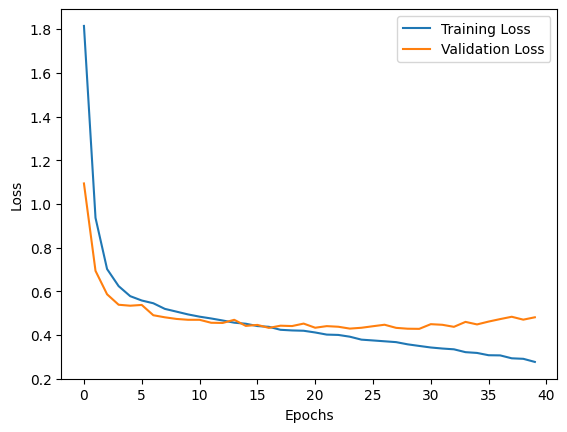

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.840418, Val. Loss: 1.265224, F1: 0.453938
Epoch 2, Train Loss: 1.149218, Val. Loss: 0.977069, F1: 0.632543
Epoch 3, Train Loss: 0.902034, Val. Loss: 0.785990, F1: 0.726790
Epoch 4, Train Loss: 0.776671, Val. Loss: 0.739675, F1: 0.730648
Epoch 5, Train Loss: 0.747766, Val. Loss: 0.698948, F1: 0.768299
Epoch 6

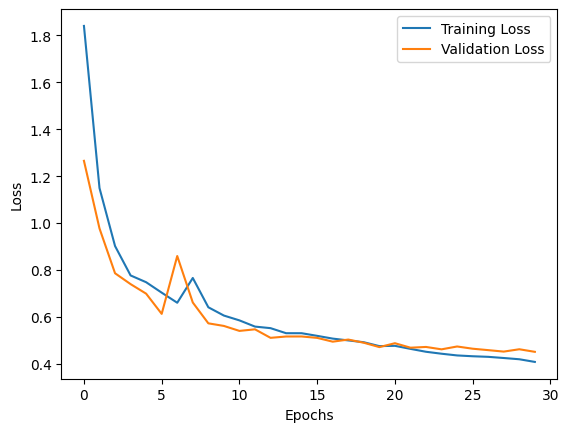

In [ ]:
print("Experiment A-2: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-3: RNN
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.817451, Val. Loss: 1.321051, F1: 0.500407
Epoch 2, Train Loss: 1.184797, Val. Loss: 1.147904, F1: 0.545026
Epoch 3, Train Loss: 1.264637, Val. Loss: 1.203277, F1: 0.482574
Epoch 4, Train Loss: 1.165175, Val. Loss: 1.269502, F1: 0.502718
Epoch 5, Train Loss: 1.199959, Val. Loss: 1.050192, F1: 0.576966
Epoch 6, T

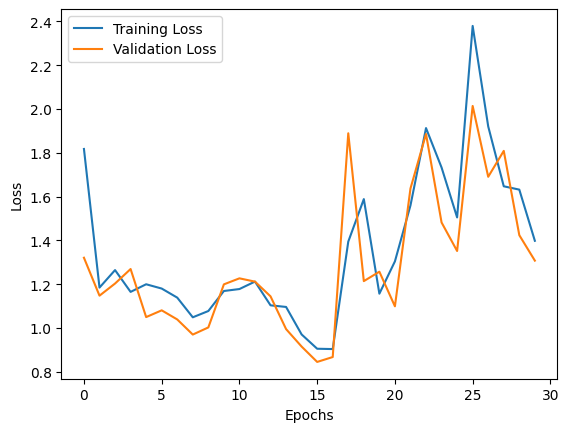

In [ ]:
print("Experiment A-3: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## B:  three different ways of combining the sequence of representations

Experiment B-1: first
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL first, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.145966, Val. Loss: 1.962851, F1: 0.280744
Epoch 2, Train Loss: 1.938728, Val. Loss: 1.883172, F1: 0.316376
Epoch 3, Train Loss: 1.889816, Val. Loss: 1.864594, F1: 0.323908
Epoch 4, Train Loss: 1.871889, Val. Loss: 1.853680, F1: 0.326690
Epoch 5, Train Loss: 1.861624, Val. Loss: 1.848344, F1: 0.324255
Epoch 6

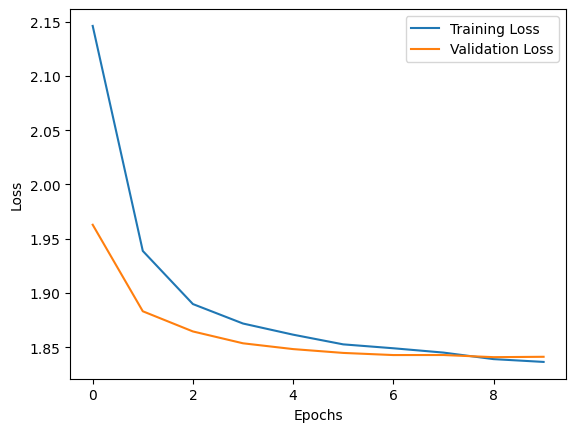

In [ ]:
print("Experiment B-1: first")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "first", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-2: add
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL add, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.786002, Val. Loss: 1.191654, F1: 0.538741
Epoch 2, Train Loss: 1.150946, Val. Loss: 0.987165, F1: 0.631291
Epoch 3, Train Loss: 1.020231, Val. Loss: 0.917674, F1: 0.657242
Epoch 4, Train Loss: 0.998631, Val. Loss: 1.011367, F1: 0.650182
Epoch 5, Train Loss: 0.950007, Val. Loss: 0.816468, F1: 0.708440
Epoch 6, Tr

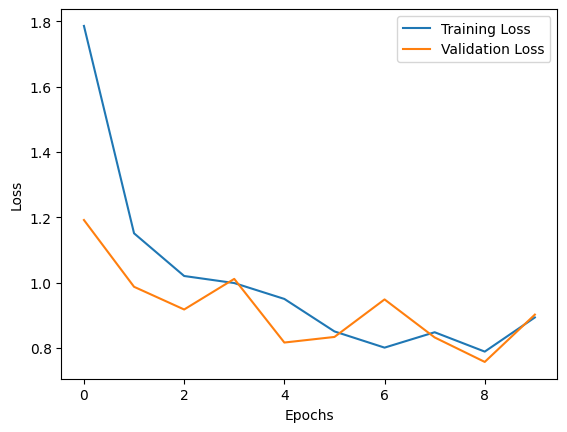

In [ ]:
print("Experiment B-2: add")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "add", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.795388, Val. Loss: 1.149683, F1: 0.614707
Epoch 2, Train Loss: 1.079612, Val. Loss: 0.825721, F1: 0.712185
Epoch 3, Train Loss: 0.842970, Val. Loss: 0.688044, F1: 0.752423
Epoch 4, Train Loss: 0.724989, Val. Loss: 0.618269, F1: 0.786089
Epoch 5, Train Loss: 0.664698, Val. Loss: 0.580632, F1: 0.794026
Epoch 6, Tr

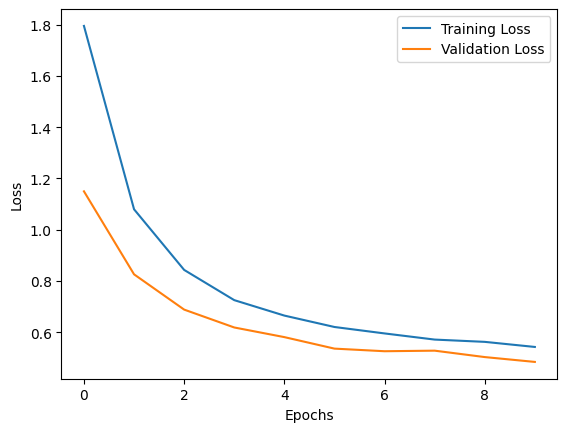

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.525728, Val. Loss: 0.684771, F1: 0.780271
Epoch 2, Train Loss: 0.772256, Val. Loss: 0.594577, F1: 0.806317
Epoch 3, Train Loss: 0.672122, Val. Loss: 0.547481, F1: 0.820907
Epoch 4, Train Loss: 0.628727, Val. Loss: 0.541204, F1: 0.821075
Epoch 5, Train Loss: 0.601972, Val. Loss: 0.523400, F1: 0.826482
Epoch 6, Tr

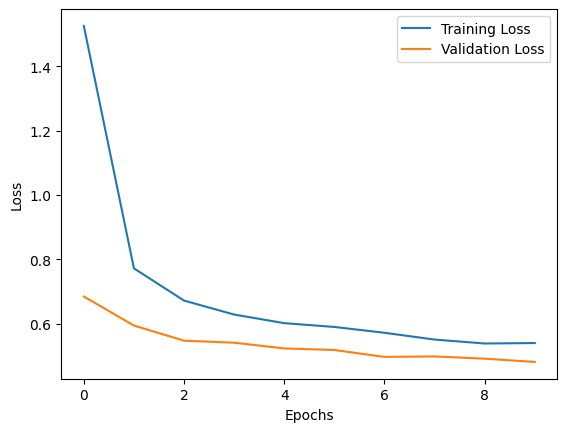

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: avg
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL average, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.966178, Val. Loss: 1.550730, F1: 0.413905
Epoch 2, Train Loss: 1.345778, Val. Loss: 1.063950, F1: 0.592098
Epoch 3, Train Loss: 1.098844, Val. Loss: 0.985402, F1: 0.673301
Epoch 4, Train Loss: 0.974136, Val. Loss: 0.833314, F1: 0.714287
Epoch 5, Train Loss: 0.852342, Val. Loss: 0.766229, F1: 0.733181
Epoch 6

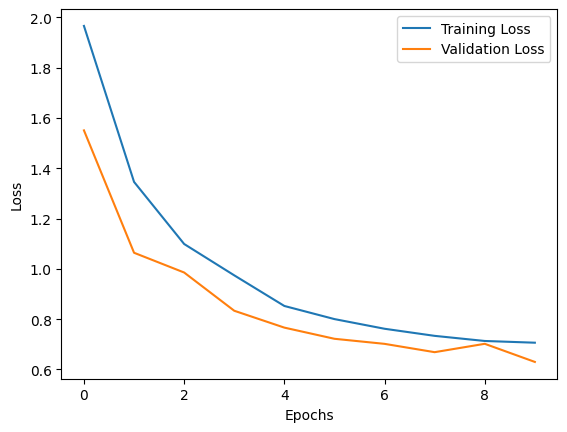

In [ ]:
print("Experiment B-3: avg")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "average", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.496216, Val. Loss: 0.686714, F1: 0.782016
Epoch 2, Train Loss: 0.760780, Val. Loss: 0.575676, F1: 0.812740
Epoch 3, Train Loss: 0.664277, Val. Loss: 0.536518, F1: 0.823180
Epoch 4, Train Loss: 0.616238, Val. Loss: 0.529785, F1: 0.827559
Epoch 5, Train Loss: 0.585071, Val. Loss: 0.503996, F1: 0.832405
Epoch 6, Tr

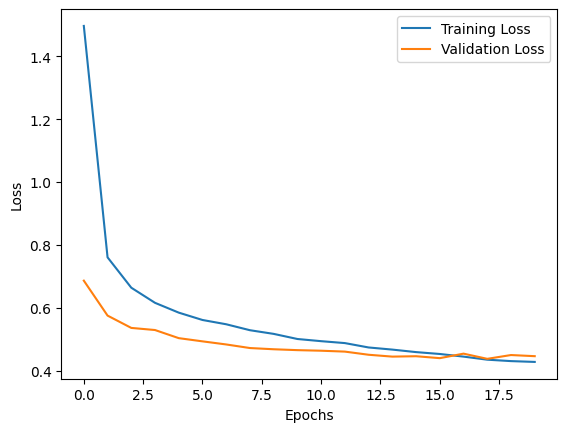

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.391988, Val. Loss: 0.682886, F1: 0.784335
Epoch 2, Train Loss: 0.744409, Val. Loss: 0.573694, F1: 0.816755
Epoch 3, Train Loss: 0.640409, Val. Loss: 0.530782, F1: 0.825501
Epoch 4, Train Loss: 0.601045, Val. Loss: 0.508328, F1: 0.831938
Epoch 5, Train Loss: 0.569778, Val. Loss: 0.493985, F1: 0.834373
Epoch 6, 

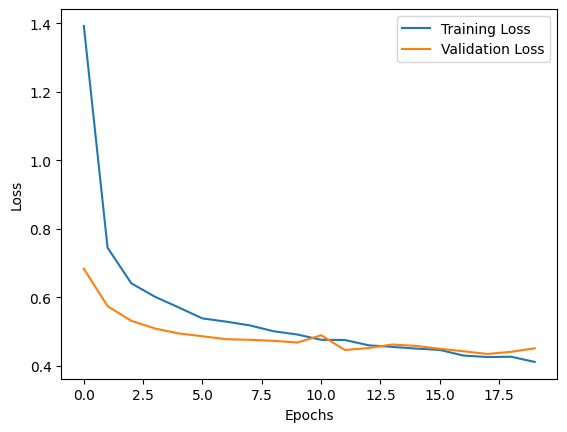

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.799362, Val. Loss: 1.063631, F1: 0.650091
Epoch 2, Train Loss: 0.944540, Val. Loss: 0.692818, F1: 0.759648
Epoch 3, Train Loss: 0.711204, Val. Loss: 0.583395, F1: 0.794483
Epoch 4, Train Loss: 0.628149, Val. Loss: 0.539197, F1: 0.812097
Epoch 5, Train Loss: 0.585219, Val. Loss: 0.513651, F1: 0.823280
Epoch 6, Tr

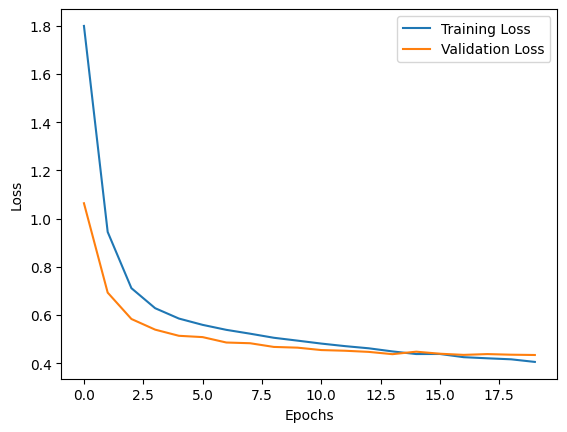

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.865308, Val. Loss: 1.275425, F1: 0.506610
Epoch 2, Train Loss: 1.072713, Val. Loss: 0.794882, F1: 0.726172
Epoch 3, Train Loss: 0.793821, Val. Loss: 0.647160, F1: 0.775092
Epoch 4, Train Loss: 0.675353, Val. Loss: 0.575733, F1: 0.800781
Epoch 5, Train Loss: 0.611660, Val. Loss: 0.527992, F1: 0.820956
Epoch 6, 

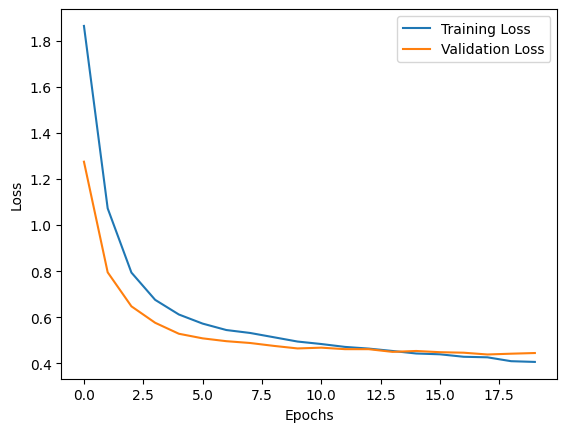

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## C:  Hyper Parameter change

### C1: Bidirectional

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  352650
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.752014, Val. Loss: 1.269867, F1: 0.502485
Epoch 2, Train Loss: 1.232913, Val. Loss: 1.168120, F1: 0.540207
Epoch 3, Train Loss: 1.137012, Val. Loss: 1.322555, F1: 0.541918
Epoch 4, Train Loss: 1.382792, Val. Loss: 1.134661, F1: 0.571930
Epoch 5, Train Loss: 1.108487, Val. Loss: 

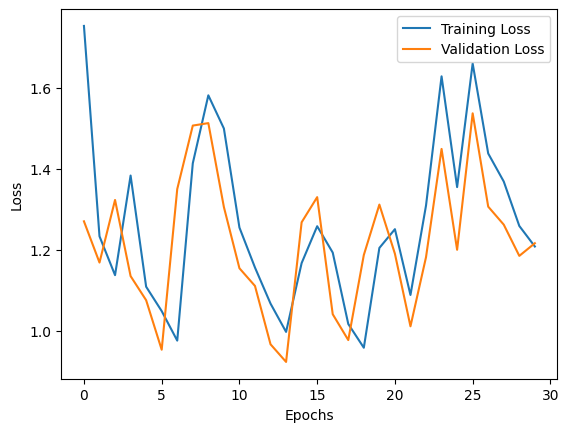

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 50, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  1209738
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.858730, Val. Loss: 1.206621, F1: 0.542801
Epoch 2, Train Loss: 1.077882, Val. Loss: 0.931175, F1: 0.661519
Epoch 3, Train Loss: 0.876443, Val. Loss: 0.739735, F1: 0.729469
Epoch 4, Train Loss: 0.764801, Val. Loss: 0.874967, F1: 0.724519
Epoch 5, Train Loss: 0.800018, Val. Lo

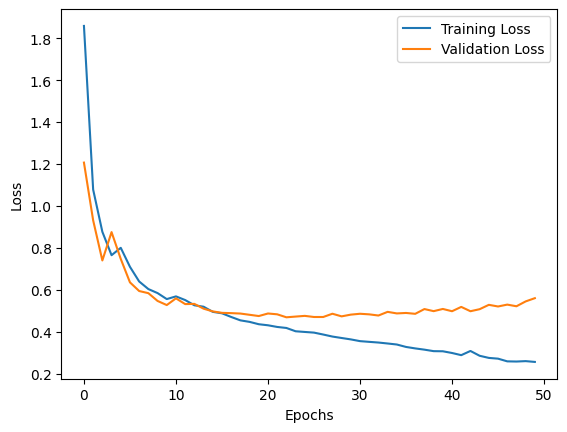

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs * 5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  924042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.745705, Val. Loss: 1.046300, F1: 0.578857
Epoch 2, Train Loss: 0.970367, Val. Loss: 0.754687, F1: 0.723009
Epoch 3, Train Loss: 0.752726, Val. Loss: 0.648085, F1: 0.759822
Epoch 4, Train Loss: 0.665152, Val. Loss: 0.585370, F1: 0.793223
Epoch 5, Train Loss: 0.612140, Val. Loss: 

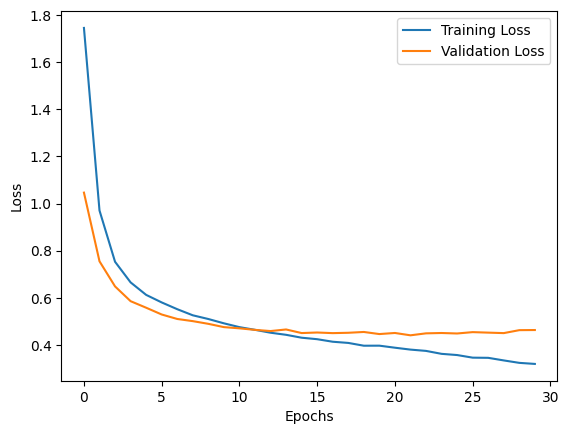

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs * 3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C2: Number of layers

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  308618
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.728437, Val. Loss: 1.166833, F1: 0.550242
Epoch 2, Train Loss: 1.203429, Val. Loss: 1.018401, F1: 0.618311
Epoch 3, Train Loss: 1.246725, Val. Loss: 1.445507, F1: 0.366163
Epoch 4, Train Loss: 1.439532, Val. Loss: 1.438879, F1: 0.469871
Epoch 5, Train Loss: 1.267583, Val. Loss: 1.020

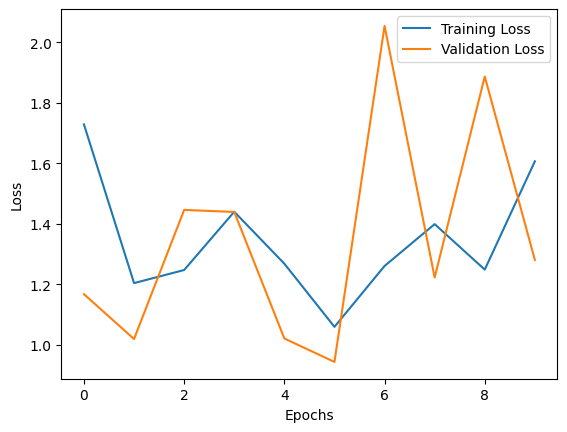

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  440202
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.659972, Val. Loss: 1.311024, F1: 0.488766
Epoch 2, Train Loss: 1.202242, Val. Loss: 1.058793, F1: 0.579593
Epoch 3, Train Loss: 1.242437, Val. Loss: 1.194890, F1: 0.523911
Epoch 4, Train Loss: 1.170559, Val. Loss: 1.000271, F1: 0.620790
Epoch 5, Train Loss: 0.998491, Val. Loss: 0.923

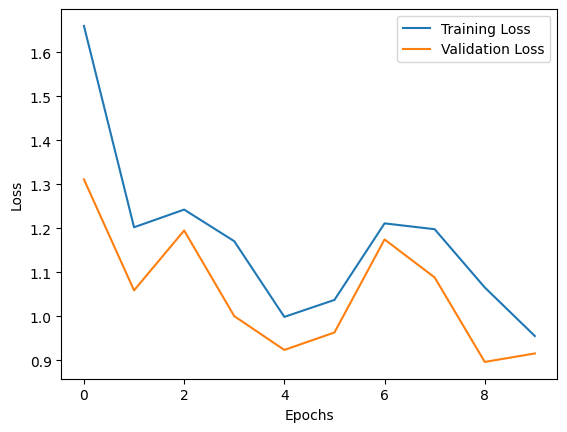

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  1197706
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.988375, Val. Loss: 1.498351, F1: 0.316012
Epoch 2, Train Loss: 1.417280, Val. Loss: 1.342204, F1: 0.372175
Epoch 3, Train Loss: 1.189757, Val. Loss: 1.034434, F1: 0.589158
Epoch 4, Train Loss: 1.023082, Val. Loss: 

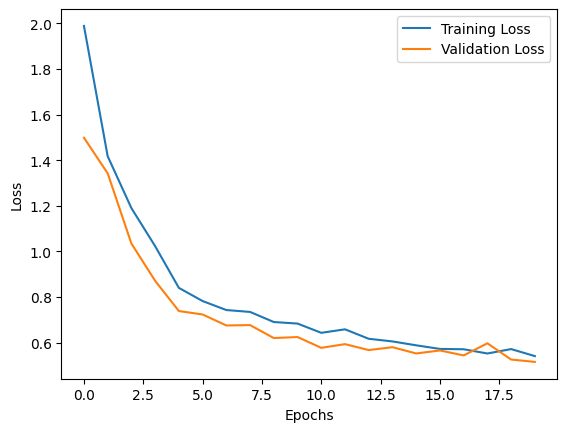

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  1724042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.929207, Val. Loss: 1.222575, F1: 0.475700
Epoch 2, Train Loss: 1.154831, Val. Loss: 0.903472, F1: 0.643982
Epoch 3, Train Loss: 0.923662, Val. Loss: 0.785136, F1: 0.712275
Epoch 4, Train Loss: 0.808750, Val. Loss: 

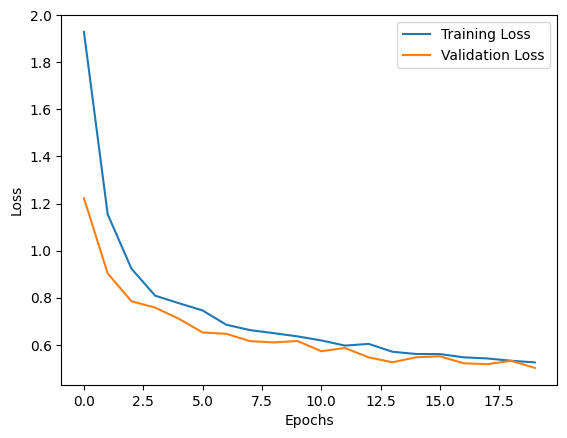

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  923274
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.833326, Val. Loss: 1.133247, F1: 0.534162
Epoch 2, Train Loss: 1.045886, Val. Loss: 0.807936, F1: 0.677572
Epoch 3, Train Loss: 0.835969, Val. Loss: 0.696581, F1: 0.745908
Epoch 4, Train Loss: 0.711999, Val. Loss: 0.5

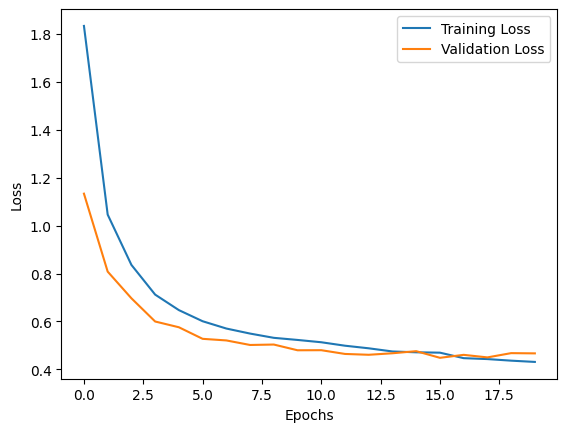

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  1318026
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.859905, Val. Loss: 1.327544, F1: 0.355484
Epoch 2, Train Loss: 1.171243, Val. Loss: 0.930433, F1: 0.591263
Epoch 3, Train Loss: 0.903956, Val. Loss: 0.792157, F1: 0.695007
Epoch 4, Train Loss: 0.777791, Val. Loss: 0.

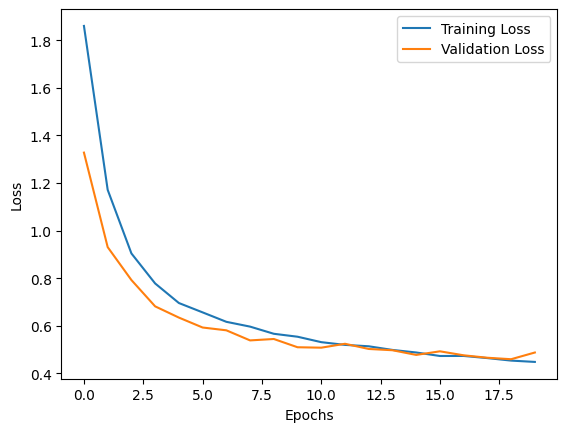

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C4 Learning Rate

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.286609, Val. Loss: 2.262383, F1: 0.293516
Epoch 2, Train Loss: 2.224630, Val. Loss: 2.164978, F1: 0.355763
Epoch 3, Train Loss: 2.032447, Val. Loss: 1.836592, F1: 0.210836
Epoch 4, Train Loss: 1.727464, Val. Loss: 1.513679, F1: 0.496702
Epoch 5, Train Loss: 1.402946, Val. Loss: 1.181228, F1: 0.558901
Epoch 6, 

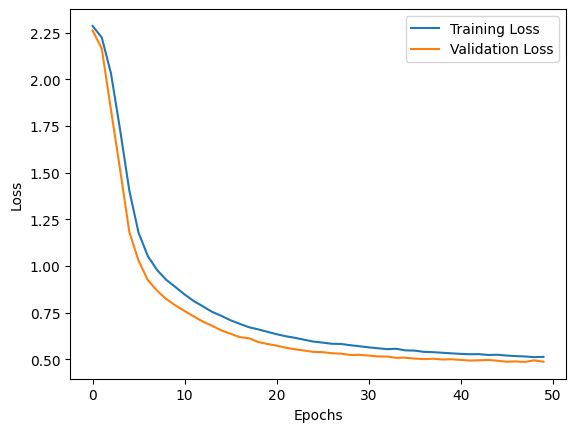

In [ ]:
print("Experiment C-4-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.293727, Val. Loss: 2.279645, F1: 0.168114
Epoch 2, Train Loss: 2.247861, Val. Loss: 2.179710, F1: 0.348812
Epoch 3, Train Loss: 1.964399, Val. Loss: 1.711110, F1: 0.398885
Epoch 4, Train Loss: 1.660449, Val. Loss: 1.480126, F1: 0.506369
Epoch 5, Train Loss: 1.408508, Val. Loss: 1.198803, F1: 0.563154
Epoch 

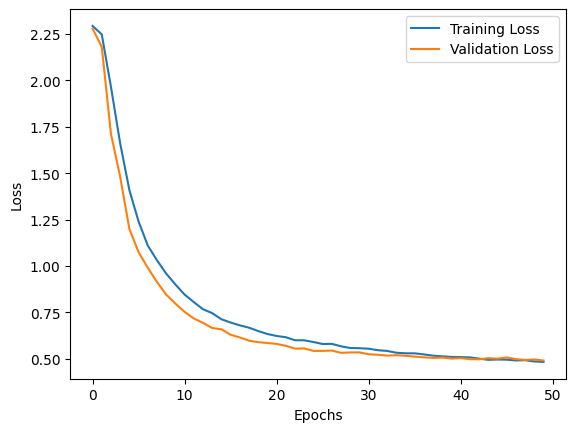

In [ ]:
print("Experiment C-4-2: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: RNN
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.279485, Val. Loss: 2.238904, F1: 0.288757
Epoch 2, Train Loss: 2.094771, Val. Loss: 1.978618, F1: 0.126097
Epoch 3, Train Loss: 1.863898, Val. Loss: 1.732933, F1: 0.324891
Epoch 4, Train Loss: 1.668698, Val. Loss: 1.551954, F1: 0.341195
Epoch 5, Train Loss: 1.566674, Val. Loss: 1.455887, F1: 0.400169
Epoch 6, 

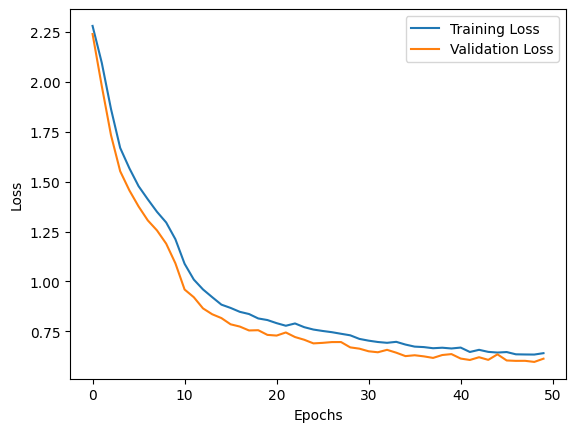

In [ ]:
print("Experiment C-4-3: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C5 Less hidden dimensions but more layers

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  105866
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.849513, Val. Loss: 1.408441, F1: 0.408081
Epoch 2, Train Loss: 1.359073, Val. Loss: 1.205379, F1: 0.511347
Epoch 3, Train Loss: 1.164773, Val. Loss: 1.056109, F1: 0.612534
Epoch 4, Train Loss: 1.057754, Val. Loss: 0.961591, F1: 0.648725
Epoch 5, Train Loss: 0.991688, Val. Loss: 0.997

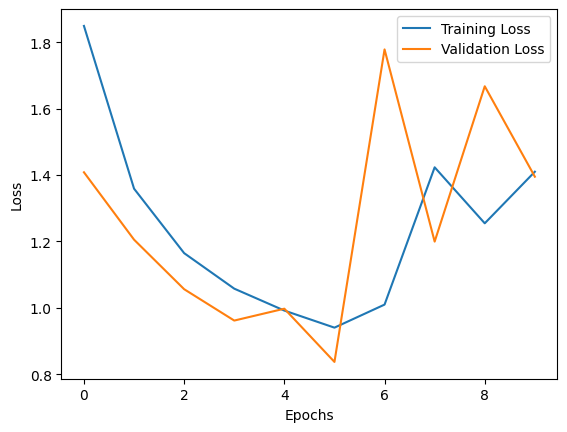

In [ ]:
print("Experiment C-5-1: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  57994
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.016208, Val. Loss: 1.586304, F1: 0.321077
Epoch 2, Train Loss: 1.479190, Val. Loss: 1.380971, F1: 0.380489
Epoch 3, Train Loss: 1.433732, Val. Loss: 1.501906, F1: 0.395110
Epoch 4, Train Loss: 1.516911, Val. Loss: 1.370536, F1: 0.439399
Epoch 5, Train Loss: 1.330733, Val. Loss: 1.203687,

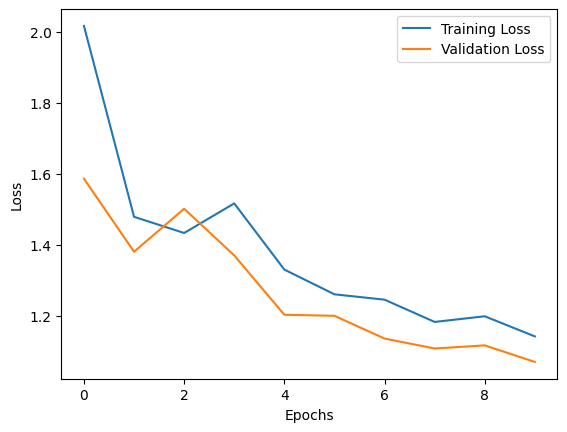

In [ ]:
print("Experiment C-5-2: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-3: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  281994
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.899698, Val. Loss: 1.297928, F1: 0.492630
Epoch 2, Train Loss: 1.082129, Val. Loss: 0.815345, F1: 0.692277
Epoch 3, Train Loss: 0.793787, Val. Loss: 0.662456, F1: 0.757448
Epoch 4, Train Loss: 0.683817, Val. Loss: 0.598816, F1: 0.784131
Epoch 5, Train Loss: 0.626874, Val. Loss: 0.559568, F1: 0.7

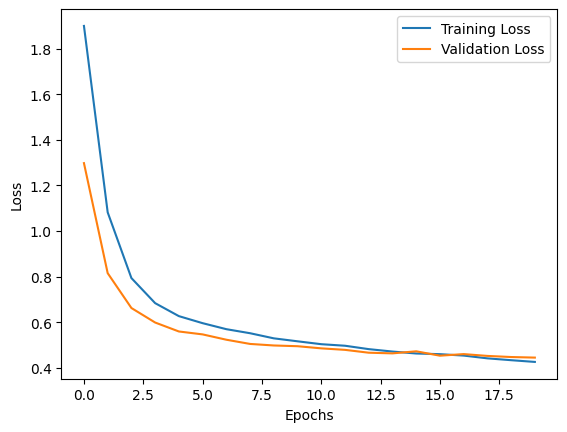

In [ ]:
print("Experiment C-5-3: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-4: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  154762
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.102928, Val. Loss: 1.583019, F1: 0.401734
Epoch 2, Train Loss: 1.289427, Val. Loss: 0.938348, F1: 0.647504
Epoch 3, Train Loss: 0.932297, Val. Loss: 0.782956, F1: 0.715745
Epoch 4, Train Loss: 0.795872, Val. Loss: 0.709964, F1: 0.750248
Epoch 5, Train Loss: 0.728007, Val. Loss: 0.658629, F1: 0.7669

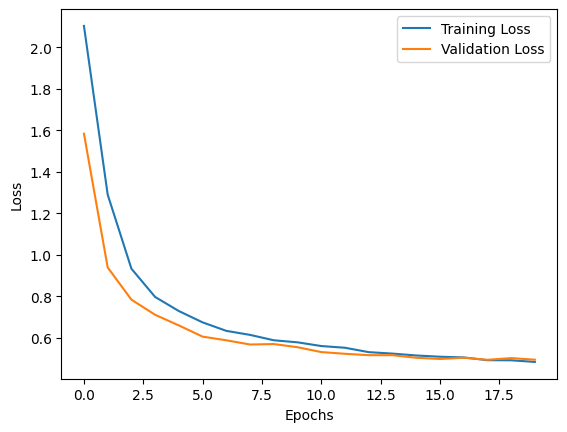

In [ ]:
print("Experiment C-5-4: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-5: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  370058
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.975810, Val. Loss: 1.289712, F1: 0.488125
Epoch 2, Train Loss: 1.134083, Val. Loss: 0.903509, F1: 0.659890
Epoch 3, Train Loss: 0.922726, Val. Loss: 0.797652, F1: 0.708589
Epoch 4, Train Loss: 0.814705, Val. Loss: 0.722428, F1: 0.745420
Epoch 5, Train Loss: 0.751476, Val. Loss: 0.674976, F1: 

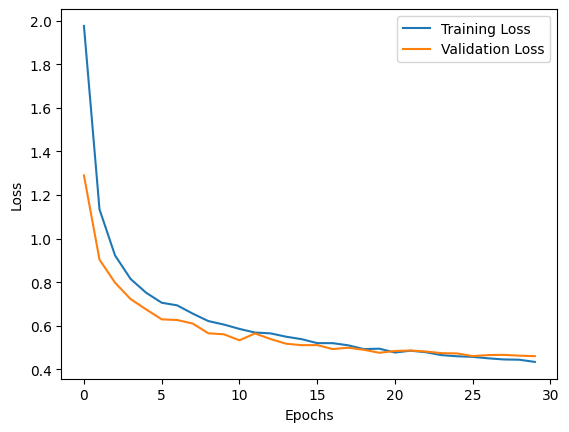

In [ ]:
print("Experiment C-5-5: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-6: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  203146
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.229234, Val. Loss: 2.069836, F1: 0.067793
Epoch 2, Train Loss: 1.981186, Val. Loss: 1.795251, F1: 0.165969
Epoch 3, Train Loss: 1.630164, Val. Loss: 1.425210, F1: 0.356663
Epoch 4, Train Loss: 1.393107, Val. Loss: 1.336814, F1: 0.382546
Epoch 5, Train Loss: 1.271564, Val. Loss: 1.177410, F1: 0.4

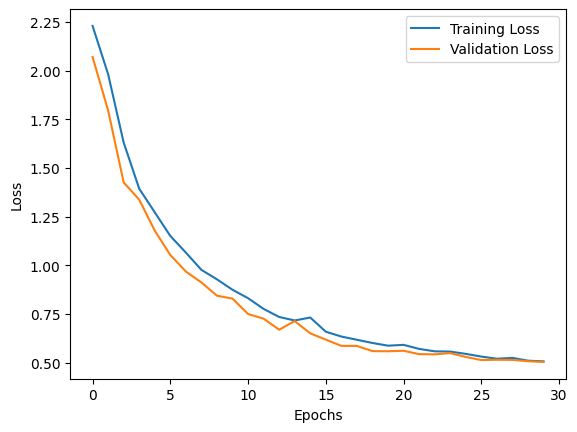

In [ ]:
print("Experiment C-5-6: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C6 Bidirectional and reduced learning rate

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  352650
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.277030, Val. Loss: 2.234114, F1: 0.279890
Epoch 2, Train Loss: 2.115409, Val. Loss: 1.971804, F1: 0.277319
Epoch 3, Train Loss: 1.875249, Val. Loss: 1.725905, F1: 0.433904
Epoch 4, Train Loss: 1.597464, Val. Loss: 1.419540, F1: 0.469729
Epoch 5, Train Loss: 1.422419, Val. Loss:

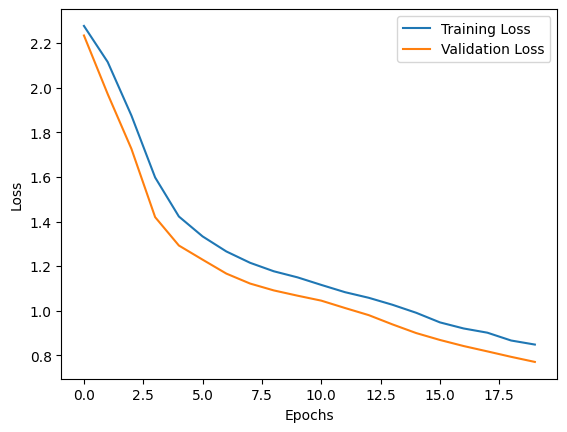

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  924042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.285126, Val. Loss: 2.258268, F1: 0.259658
Epoch 2, Train Loss: 2.215667, Val. Loss: 2.148937, F1: 0.372248
Epoch 3, Train Loss: 1.994428, Val. Loss: 1.716731, F1: 0.361185
Epoch 4, Train Loss: 1.574399, Val. Loss: 1.349311, F1: 0.538886
Epoch 5, Train Loss: 1.315050, Val. Loss:

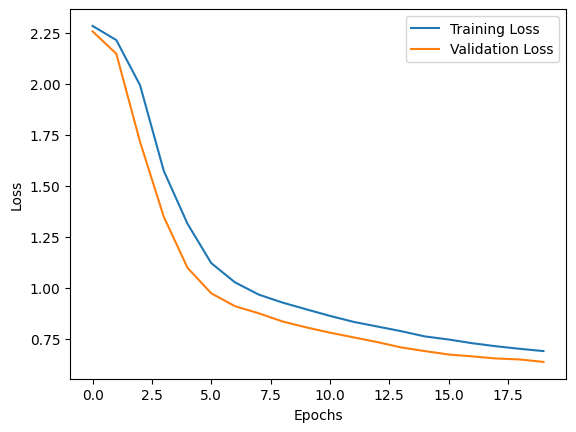

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  1209738
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.293753, Val. Loss: 2.279069, F1: 0.142679
Epoch 2, Train Loss: 2.247867, Val. Loss: 2.183437, F1: 0.347159
Epoch 3, Train Loss: 1.953193, Val. Loss: 1.624476, F1: 0.421306
Epoch 4, Train Loss: 1.449499, Val. Loss: 1.211341, F1: 0.582329
Epoch 5, Train Loss: 1.217107, Val. L

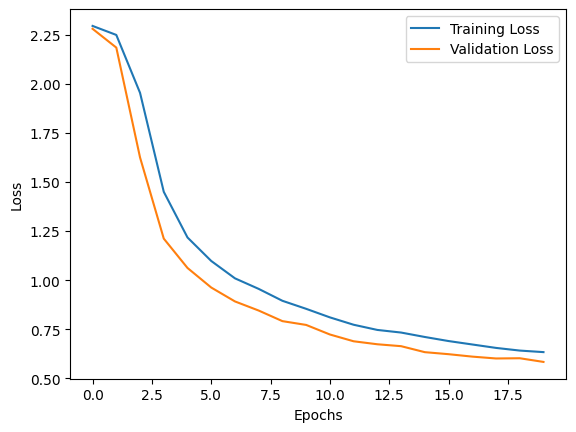

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C7 Bidirectional and higher layers with reduced learning rate

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  746890
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.239858, Val. Loss: 2.095406, F1: 0.343343
Epoch 2, Train Loss: 1.842494, Val. Loss: 1.568836, F1: 0.407557
Epoch 3, Train Loss: 1.516922, Val. Loss: 1.304643, F1: 0.515752
Epoch 4, Train Loss: 1.273292, Val. Loss: 1.094397, F1: 0.577540
Epoch 5, Train Loss: 1.1181

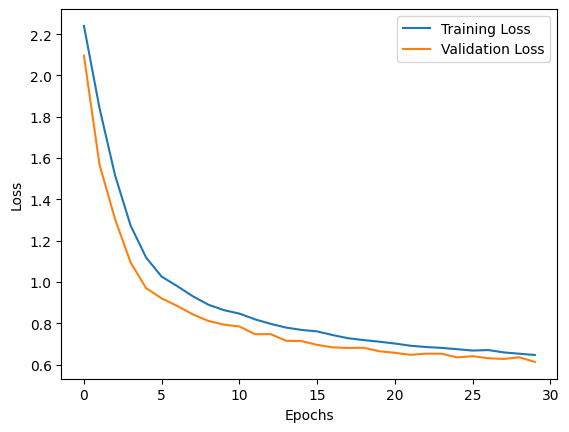

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  2106762
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.272756, Val. Loss: 2.220472, F1: 0.384675
Epoch 2, Train Loss: 2.076113, Val. Loss: 1.809106, F1: 0.372619
Epoch 3, Train Loss: 1.601676, Val. Loss: 1.269456, F1: 0.550008
Epoch 4, Train Loss: 1.218812, Val. Loss: 0.994619, F1: 0.619009
Epoch 5, Train Loss: 1.030

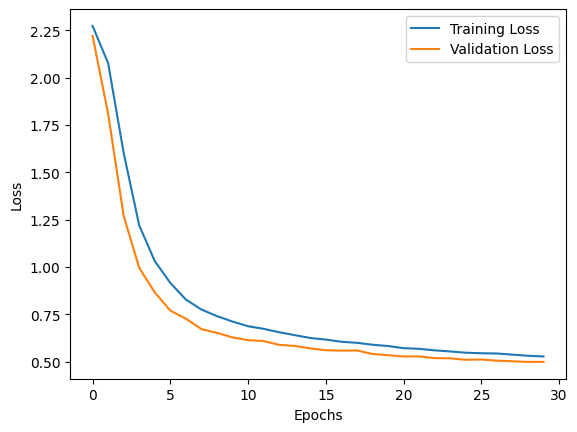

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  2786698
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.295302, Val. Loss: 2.281656, F1: 0.165374
Epoch 2, Train Loss: 2.208279, Val. Loss: 1.953019, F1: 0.192078
Epoch 3, Train Loss: 1.582237, Val. Loss: 1.182225, F1: 0.559190
Epoch 4, Train Loss: 1.151479, Val. Loss: 0.934704, F1: 0.668751
Epoch 5, Train Loss: 0.

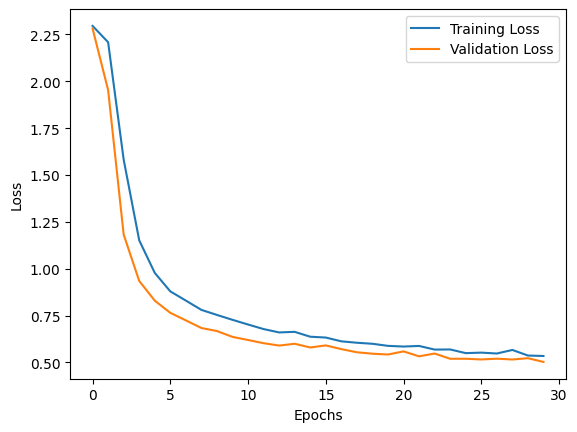

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C8 Higher number of linear layers

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128, 64], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  470346
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.046586, Val. Loss: 1.460834, F1: 0.393085
Epoch 2, Train Loss: 1.279263, Val. Loss: 0.879275, F1: 0.633772
Epoch 3, Train Loss: 0.948117, Val. Loss: 0.744461, F1: 0.690212
Epoch 4, Train Loss: 0.832850, Val. Loss: 0.659484, F1: 0.754294
Epoch 5, Tr

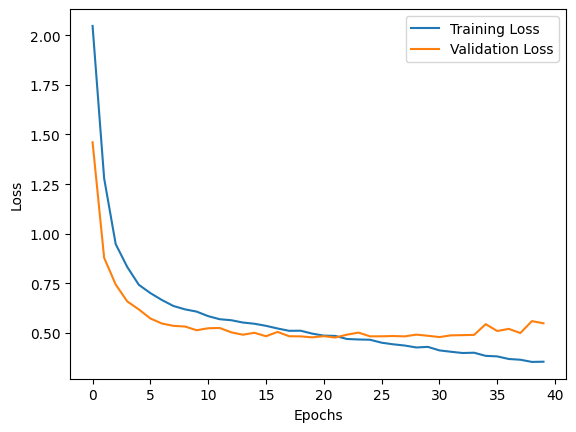

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128, 64, 32], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  472106
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=32, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.195263, Val. Loss: 1.790066, F1: 0.244750
Epoch 2, Train Loss: 1.696117, Val. Loss: 1.169631, F1: 0.533452
Epoch 3, Train Loss: 1.320720, Val. Loss: 0.920392, F1: 0.654899
Epoch 4, Tra

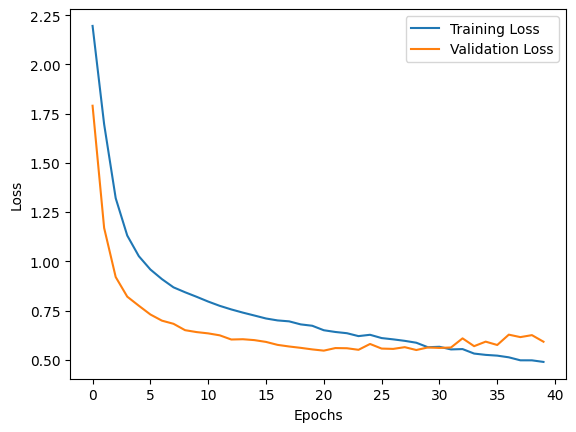

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128, 64, 32], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128, 64], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  536138
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.086930, Val. Loss: 1.610756, F1: 0.337632
Epoch 2, Train Loss: 1.477934, Val. Loss: 1.048528, F1: 0.509907
Epoch 3, Train Loss: 1.066097, Val. Loss: 0.824196, F1: 0.646353
Epoch 4, 

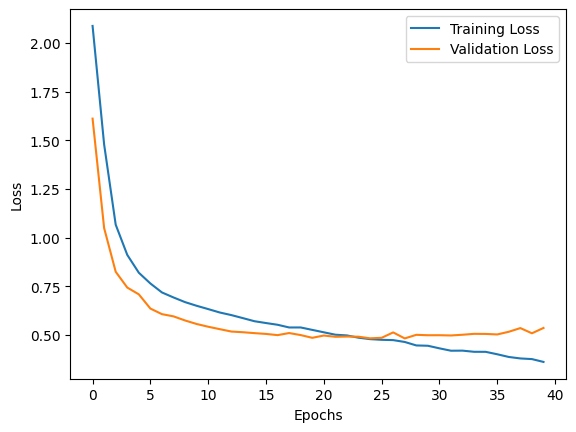

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[256, 128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### MIX

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: False, model_layer_map: [128, 64], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  48587814
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.193313, Val. Loss: 1.883700, F1: 0.452155
Epoch 2, Train Loss: 1.813840, Val. Loss: 1.344175, F1: 0.631451
Epoch 3, Train Loss: 1.450487, Val. Loss: 0.924709, F1: 0.755682
Epoch 4, Train Loss: 1.

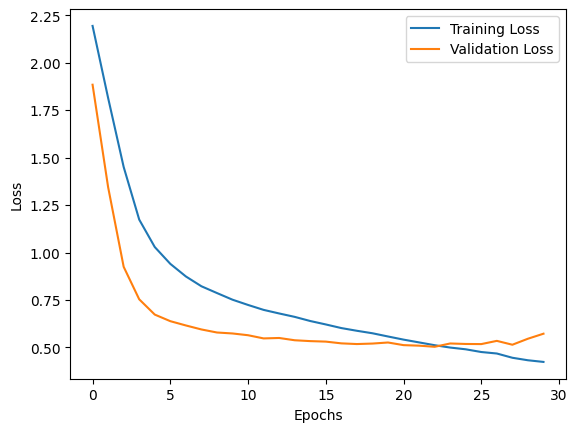

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=False,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: False, model_layer_map: [128, 64], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL sum, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  47907878
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.165334, Val. Loss: 1.638250, F1: 0.606806
Epoch 2, Train Loss: 1.699664, Val. Loss: 1.216512, F1: 0.726987
Epoch 3, Train Loss: 1.450498, Val. Loss: 0.975705, F1: 0.772287
Epoch 4, Train Loss: 1.26

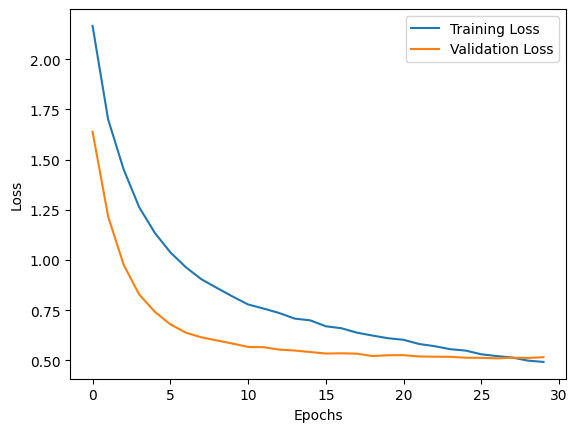

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=False,
                                         RNN_type='GRU', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## D: Best Model search

In [ ]:
# # Search and Save Best Model
# model_best, train_loss, val_loss = train_evaluate(lr_=0.001, epochs_=50, batch_size_=2048, hidden_dim=256, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
#                                          RNN_type='RNN', fusion_type = "last", num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
# plot_loss_curve(train_loss, val_loss)
# torch.save(model_best.to('cpu'), "best_model.bin")

## _Load necessary libraries and prepare dataset

# SUSHANT is working here.. . dont save

In [ ]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from datasets import load_dataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim import corpora, models, similarities, downloader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import numpy as np
np.random.seed(42)

/home/sushant/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
transformation = lambda s: " ".join([lemmatizer.lemmatize(word) for word in re.sub('[\W\d]+', ' ', s).lower().split() if word not in stop_words])

# read /fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz
dataset = pd.read_csv("./../test/arxiv_train.csv.gz", compression="gzip")
dataset['abstract_org'] = dataset['abstract'] #backup
dataset['abstract'] = dataset['abstract'].apply(transformation)

[nltk_data] Downloading package wordnet to /home/sushant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sushant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Train custom word embedding model

In [ ]:
print("Available pre-trained corpora:", list(downloader.info()['corpora'].keys()))
# print([folder for folder in os.listdir('/fp/projects01/ec30/corpora')])

Available pre-trained corpora: ['semeval-2016-2017-task3-subtaskBC', 'semeval-2016-2017-task3-subtaskA-unannotated', 'patent-2017', 'quora-duplicate-questions', 'wiki-english-20171001', 'text8', 'fake-news', '20-newsgroups', '__testing_matrix-synopsis', '__testing_multipart-matrix-synopsis']


In [ ]:
# dataset_arxiv_hf_df = pd.DataFrame({'abstract': load_dataset("gfissore/arxiv-abstracts-2021")["train"]['abstract']})
# dataset_arxiv_hf_df['abstract'] = dataset_arxiv_hf_df['abstract'].apply(transformation)
# concatenated_df = pd.concat([pd.DataFrame({'abstract': dataset['abstract'].values}), dataset_arxiv_hf_df], ignore_index=True)
# concatenated_df_ = concatenated_df.dropna(subset=['abstract'])
# concatenated_df_.to_csv('corpus.csv', index=False)
# corpus_to_train = concatenated_df['abstract']

# corpus_to_train = pd.read_csv('corpus.csv').dropna()['abstract']

In [ ]:
# #number of abstracts in corpus_to_train : 2,079,484, from dataset_arxiv_hf: 2M  from our dataset['abstract']: 80K
# print("Total number of tokens:", corpus_to_train.apply(lambda x: len(x.split())).sum()) # 179,355,863
# print("Number of unique tokens:", len(set(" ".join(corpus_to_train).split()))) # 471,322

In [ ]:
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch > 0:
            current_loss = loss - self.prev_loss
            self.losses.append(current_loss)
            print(f'Epoch {self.epoch}: Loss: {current_loss}')
        else:
            self.losses.append(loss)
            print(f'Epoch {self.epoch}: Loss: {loss}')
        self.prev_loss = loss
        self.epoch += 1

In [ ]:
# corpus_gn = corpus_to_train.apply(lambda x: x.split()).values[:10]
# model_gn = Word2Vec(vector_size=300, window=5, min_count=5, workers=60, epochs=20, sg=1)
# model_gn.build_vocab(corpus_iterable=corpus_gn)
# print('\n'.join([f"{member}: {size / (1024 * 1024):.2f} MB" for member, size in model_gn.estimate_memory().items()]))

In [ ]:
# loss_logger = LossLogger()
# model_gn.train(corpus_gn, total_examples=len(corpus_gn), epochs=model_gn.epochs, compute_loss=True, callbacks=[loss_logger])
# loss_logger.losses = [28249280.0, 16752928.0, 14551592.0, 8131464.0, 1066216.0, 1044392.0, 1033128.0, 1092200.0, 1011840.0, 979288.0, 932632.0, 941664.0, 908408.0, 856944.0, 844160.0, 841848.0, 884648.0, 811488.0, 818648.0, 762072.0]
# print(loss_logger.losses)
# plt.plot(loss_logger.losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss per Epoch of out custom word embedding model')
# plt.show()
# model_gn.wv.vectors.shape #model.wv.index_to_key

In [ ]:
# model.save("xword2vec_300_5_5_20_1")

## Choose and load Pretrained models

In [ ]:
print("Available pre-trained modules:", list(downloader.info()['models'].keys()))

Available pre-trained modules: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# model_list = {
#             "glove-twitter-25": downloader.load("glove-twitter-25"),
#             "word2vec-google-news-300": downloader.load("word2vec-google-news-300"),
#             "glove-wiki-gigaword-300": downloader.load("glove-wiki-gigaword-300"),
#             "fasttext-wiki-news-subwords-300": downloader.load("fasttext-wiki-news-subwords-300"),
#         }

In [ ]:
# all_words = [word for abstract in dataset['abstract'] for word in abstract.split()]
# unique_words = set(all_words)
# print("Total Words in our corpus:", len(all_words))
# print("Unique words in our corpus:", len(unique_words))

# for model_name in ['glove-twitter-25', 'word2vec-google-news-300', 'glove-wiki-gigaword-300', 'fasttext-wiki-news-subwords-300']:
#     word_model = model_list[model_name]
#     words_in_model = [word for word in all_words if word in word_model]
#     unique_words_in_model =  set(words_in_model)
#     print("\n>> {} Model loaded.".format(model_name))
#     print(f"Unique words from our corpus present in model: {len(unique_words_in_model)} ({(len(unique_words_in_model) / len(unique_words)) * 100:.2f}%)")
#     print(f"Total words from our corpus present in model: {len(words_in_model)} ({(len(words_in_model) / len(all_words)) * 100:.2f}%)")
#     print("Total number of vocabulary words in model:", len(word_model.index_to_key))

- Total Words in our corpus: 7950716
-  Unique words in our corpus: 85756

**GloVe Twitter 25 Model:**
- Unique words from our corpus present in model: 36,883 (43.01%)
- Total words from our corpus present in model: 7,360,299 (92.57%)
- Total number of vocabulary words in model: 1,193,514

**Word2Vec Google News 300 Model:**
- Unique words from our corpus present in model: 34,500 (40.23%)
- Total words from our corpus present in model: 7,501,847 (94.35%)
- Total number of vocabulary words in model: 3,000,000

**GloVe Wiki Gigaword 300 Model:**
- Unique words from our corpus present in model: 44,642 (52.06%)
- Total words from our corpus present in model: 7,694,945 (96.78%)
- Total number of vocabulary words in model: 400,000

**FastText Wiki News Subwords 300 Model:**
- Unique words from our corpus present in model: 40,637 (47.39%)
- Total words from our corpus present in model: 7,664,711 (96.40%)
- Total number of vocabulary words in model: 999,999


## Define models and dataloader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['abstract'].values, dataset['label'].values, test_size=0.3, random_state=42, stratify=dataset['label'])
id2label = dict(enumerate(dataset['label'].unique()))
label2id = {v: k for k, v in id2label.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, word_emb_model, unk_index):
        self.unk_index = unk_index
        self.tokens = [
            [
                word_emb_model.get(token.lower(), self.unk_index)
                for token in sentence.split()
            ]
            for sentence in sentences
        ]

        unk_tokens = sum(token == self.unk_index for document in self.tokens for token in document)
        n_tokens = sum(len(document) for document in self.tokens)
        print(f"Percentage of unknown tokens: {unk_tokens / n_tokens * 100.0:.2f}%")
        self.label = list(labels)


    def __getitem__(self, index):
        current_tokens = self.tokens[index]
        current_label = self.label[index]

        x = torch.LongTensor(current_tokens)
        y = torch.LongTensor([label2id[current_label]])
        return x, y

    def __len__(self):
        return len(self.tokens)

class CollateFunctor:
    def __init__(self, padding_index: int, max_length: int):
        self.padding_index = padding_index
        self.max_length = max_length

    # Gets a list of outputs from the dataset and outputs tensors
    def __call__(self, samples):
        input_ids = [x for x, _ in samples]
        labels = [y for _, y in samples]
        lengths = torch.tensor([len(x) for x in input_ids], dtype=torch.long)

        input_ids_padded = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first = True,
            padding_value=self.padding_index,
        )
        input_ids_padded = input_ids_padded[:, :self.max_length]
        return input_ids_padded, lengths.long(), torch.LongTensor(labels)


num_classes = len(id2label)

In [ ]:
def getWordWV(oov_handler, model_name):
    if "custom_" in model_name:
        word_model = gensim.models.KeyedVectors.load("./../word_embeddings/"+model_name.replace("custom_", "")).wv
    else:
        word_model = model_list[model_name]

    if oov_handler =="mean":
        word_model["[UNK]"] = torch.tensor(word_model.vectors).mean(dim=0).numpy() #average
    elif oov_handler =="random":
        word_model["[UNK]"] = np.random.uniform(low=-0.3, high=0.3, size=(word_model.vector_size,)) # random''
    else:
        word_model["[UNK]"] = torch.zeros(word_model.vector_size).numpy()

    word_model["[PAD]"] = torch.zeros(word_model.vector_size).numpy()
    return word_model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, layer_map=[128], dropout_rate=0.5, merge_operation='XXX', embedding_type='xxx', oov_handler="xxx", freeze_emb=True, RNN_type='xxx', fusion_type='xxx', hidden_dim=None, num_layers=None, bidirectional=None):
        super().__init__()
        # Assume getWordWV, label2id are defined elsewhere
        embedding_wv = getWordWV(oov_handler, embedding_type)
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_wv.vectors), freeze=freeze_emb)
        self.embedding_dim = embedding_wv.vector_size
        self.key_to_index = embedding_wv.key_to_index
        self.pad_index = embedding_wv.get_index("[PAD]")
        self.unk_index = embedding_wv.get_index("[UNK]")
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.RNN_type = RNN_type.lower()
        self.merge_operation = merge_operation.lower()
        self.fusion_type = fusion_type.lower()

        rnn_input_size = self.embedding_dim
        rnn_layer = {'gru': nn.GRU, 'lstm': nn.LSTM, 'rnn': nn.RNN}.get(self.RNN_type)
        if rnn_layer:
            self.rnn = rnn_layer(rnn_input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError(f"Unsupported RNN_type: {RNN_type}")

        self.fc_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        for size in layer_map:
            self.fc_layers.append(nn.Linear(fc_input_dim, size))  # Adjusting input size for FC layers
            self.hidden_dim = size  # Updating hidden_dim to match the output of the current layer
            fc_input_dim = size

        self.fc_out = nn.Linear(self.hidden_dim, len(label2id))  # Assuming label2id is defined elsewhere

    # def forward(self, x):
    #     batch_size = x.size(0)
    #     embedded = self.embedding(x)
    #     rnn_out, _ = self.rnn(embedded)

    #     if self.fusion_type == 'last':
    #         rnn_out = rnn_out[:, -1, :]
    #     elif self.fusion_type == 'first':
    #         rnn_out = rnn_out[:, 0, :]
    #     # elif self.fusion_type == 'concat':
    #     #     rnn_out = torch.cat((rnn_out[:, 0, :], rnn_out[:, -1, :]), dim=1)
    #     #     self.fc_layers[0] = nn.Linear(self.hidden_dim * 2, self.fc_layers[0].out_features)
    #     elif self.fusion_type == 'add':
    #         rnn_out = rnn_out[:, 0, :] + rnn_out[:, -1, :]
    #     elif self.fusion_type == 'max':
    #         rnn_out, _ = torch.max(rnn_out, dim=1)
    #     else:
    #         raise ValueError(f"Unsupported fusion_type: {self.fusion_type}")

    #     rnn_out =rnn_out.to(device)
    #     for layer in self.fc_layers.to(device):
    #         rnn_out = F.relu(layer(rnn_out))
    #         rnn_out = self.dropout(rnn_out)

    #     output = self.fc_out(rnn_out)
    #     return output


    # def forward(self, x, batch_of_lengths):
    #     batch_size = x.size(0)
    #     embedded = self.embedding(x)

    #     packed_embeddings = pack_padded_sequence(embedded, batch_of_lengths, batch_first=True, enforce_sorted=False)
    #     rnn_out, _ = self.rnn(packed_embeddings)
    #     rnn_out, outputs_lengths = pad_packed_sequence(rnn_out, batch_first=True)

    #     if self.fusion_type == 'last':
    #         rnn_out = rnn_out[:, -1, :]
    #     elif self.fusion_type == 'first':
    #         rnn_out = rnn_out[:, 0, :]
    #     # elif self.fusion_type == 'concat':
    #     #     rnn_out = torch.cat((rnn_out[:, 0, :], rnn_out[:, -1, :]), dim=1)
    #     #     self.fc_layers[0] = nn.Linear(self.hidden_dim * 2, self.fc_layers[0].out_features)
    #     elif self.fusion_type == 'add':
    #         rnn_out = rnn_out[:, 0, :] + rnn_out[:, -1, :]
    #     elif self.fusion_type == 'max':
    #         rnn_out, _ = torch.max(rnn_out, dim=1)
    #     else:
    #         raise ValueError(f"Unsupported fusion_type: {self.fusion_type}")

    #     rnn_out =rnn_out.to(device)
    #     for layer in self.fc_layers.to(device):
    #         rnn_out = F.relu(layer(rnn_out))
    #         rnn_out = self.dropout(rnn_out)

    #     output = self.fc_out(rnn_out)
    #     return output

    def forward(self, x, lengths):
        batch_size = x.size(0)
        embedded = self.embedding(x)

        # Pack the padded sequence
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Process with RNN
        packed_rnn_out, _ = self.rnn(packed_embedded)

        # If you need the output for each sequence, unpack the sequence
        # rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

        # Handling different fusion types
        if self.fusion_type == 'last':
            if self.RNN_type == 'LSTM':
                num_directions = 2 if self.rnn.bidirectional else 1
                if num_directions == 2:
                    # concatenate the hidden states from the last layer of both directions
                    h_n_last_layer = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)
                else:
                    # take the last layer's hidden state
                    h_n_last_layer = h_n[-1, :, :]
                    rnn_out = h_n_last_layer
            else:
                rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
                rnn_out = rnn_out[torch.arange(batch_size), lengths - 1]
        elif self.fusion_type == 'first':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = rnn_out[:, 0, :]
        # Add or modify fusion types as needed
        elif self.fusion_type == 'add':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = rnn_out[:, 0, :] + rnn_out[torch.arange(batch_size), lengths - 1]
        elif self.fusion_type == 'max':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out, _ = torch.max(rnn_out, dim=1)
        elif self.fusion_type == 'sum':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = torch.sum(rnn_out, dim=1)
        elif self.fusion_type == 'average':
            rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)
            rnn_out = torch.mean(rnn_out, dim=1)
        else:
            raise ValueError(f"Unsupported fusion_type: {self.fusion_type}")

        rnn_out = rnn_out.to(device)
        for layer in self.fc_layers.to(device):
            rnn_out = F.relu(layer(rnn_out))
            rnn_out = self.dropout(rnn_out)

        output = self.fc_out(rnn_out)
        return output

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, lengths, labels in data_loader:
            inputs = inputs.squeeze(1).to(device)
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values()), zero_division=0))


def plot_loss_curve(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def train(model, criterion, _optimizer, train_loader, val_loader, epochs, verbose):
    model.to(device)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, lengths, labels in train_loader:
            inputs, lengths, labels = inputs.squeeze(1).to(device), lengths, labels.to(device)

            _optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, lengths, labels in val_loader:
                inputs, lengths, labels = inputs.squeeze(1).to(device), lengths, labels.to(device)
                outputs = model(inputs, lengths)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        val_loss.append(running_loss / len(val_loader))
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
        if verbose:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.6f}, Val. Loss: {val_loss[-1]:.6f}, F1: {f1:.6f}')
                        # Precision: {precision:.6f}, Recall: {recall:.6f},
        else:
            print(f'{f1*100:.2f},', end=" ")
    print("")
    return train_loss, val_loss

In [ ]:
max_length = 280 #260
criterion = nn.CrossEntropyLoss()
def train_evaluate(embedding_type, oov_handler, freeze_emb, model_layer_map, lr_, epochs_, batch_size_, RNN_type, fusion_type, hidden_dim, num_layers, bidirectional, verbose_=False):
    print("Model with embedding_type: {}, oov_handler: {}, freeze_emb: {}, model_layer_map: {}, lr: {}, epochs: {}, batch_size: {}, RNN_type: {}, fusion_typeL {}, hidden_dim: {}, num_layers: {}, bidirectional: {}".format(embedding_type, oov_handler, freeze_emb, model_layer_map, lr_, epochs_, batch_size_, RNN_type, fusion_type, hidden_dim, num_layers, bidirectional))

    model = TextClassifier(layer_map=model_layer_map, embedding_type=embedding_type, oov_handler=oov_handler, freeze_emb=freeze_emb, RNN_type=RNN_type, fusion_type=fusion_type, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
    print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    train_loader = DataLoader(CustomDataset(X_train, y_train, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=True, drop_last=False, collate_fn=CollateFunctor(model.pad_index, max_length))
    test_loader = DataLoader(CustomDataset(X_test, y_test, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=False, drop_last=False, collate_fn=CollateFunctor(model.pad_index, max_length))

    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
    train_loss, val_loss = train(model, criterion, optimizer, train_loader, test_loader, epochs=epochs_, verbose=verbose_)
    evaluate(model, test_loader)
    return model, train_loss, val_loss


# Experiments

##### Arguments for experimentations
-  RNN_types: rnn, lstm , gru
-  fusion_type = last, first, add, max
-  embedding_type (pretrained) = "glove-twitter-25", "word2vec-google-news-300", "glove-wiki-gigaword-300", "fasttext-wiki-news-subwords-300"
-  embedding_type (our models) = "custom_word2vec_100_5_5_10_1", "custom_word2vec_300_5_5_20_1", "custom_fasttext_100_5_5_10_1"
- oov_handler= mean, random, zero
- freeze_emb= True, False

In [ ]:
lr=0.001; batch_size=2048; epochs=10; hidden_dim=256

## A:  different kinds of recurrent network

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.814613, Val. Loss: 1.093700, F1: 0.594013
Epoch 2, Train Loss: 0.936262, Val. Loss: 0.693670, F1: 0.739493
Epoch 3, Train Loss: 0.701978, Val. Loss: 0.586425, F1: 0.785258
Epoch 4, Train Loss: 0.623768, Val. Loss: 0.538539, F1: 0.812682
Epoch 5, Train Loss: 0.577864, Val. Loss: 0.534148, F1: 0.812939
Epoch 6, T

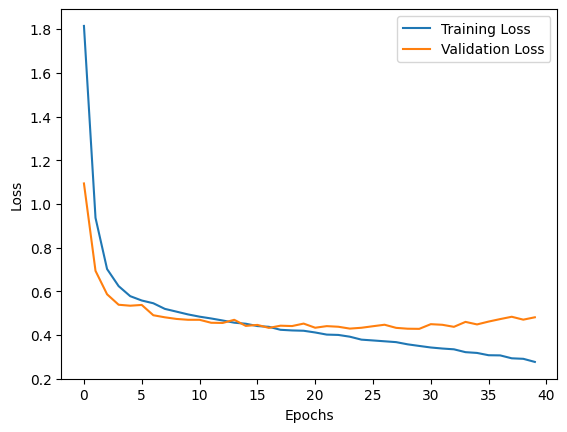

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.840418, Val. Loss: 1.265224, F1: 0.453938
Epoch 2, Train Loss: 1.149218, Val. Loss: 0.977069, F1: 0.632543
Epoch 3, Train Loss: 0.902034, Val. Loss: 0.785990, F1: 0.726790
Epoch 4, Train Loss: 0.776671, Val. Loss: 0.739675, F1: 0.730648
Epoch 5, Train Loss: 0.747766, Val. Loss: 0.698948, F1: 0.768299
Epoch 6

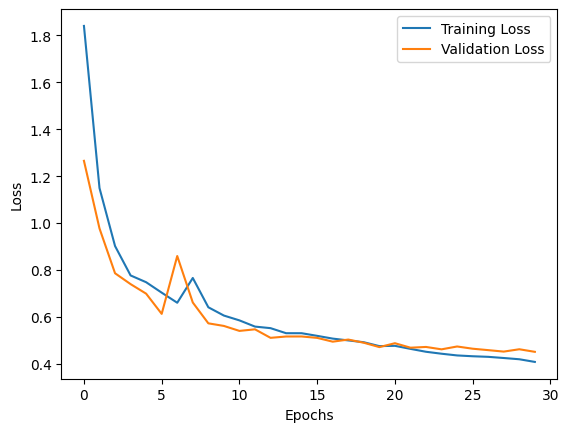

In [ ]:
print("Experiment A-2: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-3: RNN
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.817451, Val. Loss: 1.321051, F1: 0.500407
Epoch 2, Train Loss: 1.184797, Val. Loss: 1.147904, F1: 0.545026
Epoch 3, Train Loss: 1.264637, Val. Loss: 1.203277, F1: 0.482574
Epoch 4, Train Loss: 1.165175, Val. Loss: 1.269502, F1: 0.502718
Epoch 5, Train Loss: 1.199959, Val. Loss: 1.050192, F1: 0.576966
Epoch 6, T

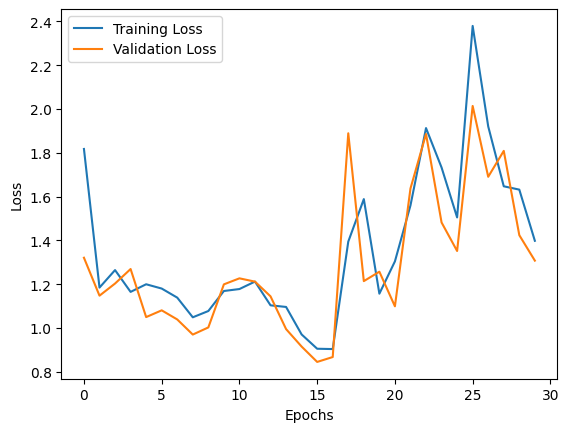

In [ ]:
print("Experiment A-3: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## B:  three different ways of combining the sequence of representations

Experiment B-1: first
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL first, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.145966, Val. Loss: 1.962851, F1: 0.280744
Epoch 2, Train Loss: 1.938728, Val. Loss: 1.883172, F1: 0.316376
Epoch 3, Train Loss: 1.889816, Val. Loss: 1.864594, F1: 0.323908
Epoch 4, Train Loss: 1.871889, Val. Loss: 1.853680, F1: 0.326690
Epoch 5, Train Loss: 1.861624, Val. Loss: 1.848344, F1: 0.324255
Epoch 6

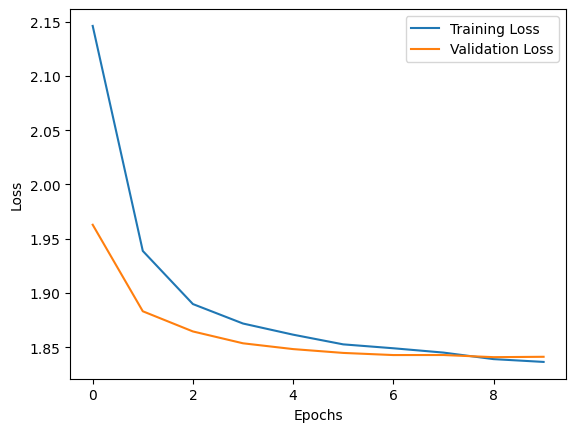

In [ ]:
print("Experiment B-1: first")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "first", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-2: add
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL add, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.786002, Val. Loss: 1.191654, F1: 0.538741
Epoch 2, Train Loss: 1.150946, Val. Loss: 0.987165, F1: 0.631291
Epoch 3, Train Loss: 1.020231, Val. Loss: 0.917674, F1: 0.657242
Epoch 4, Train Loss: 0.998631, Val. Loss: 1.011367, F1: 0.650182
Epoch 5, Train Loss: 0.950007, Val. Loss: 0.816468, F1: 0.708440
Epoch 6, Tr

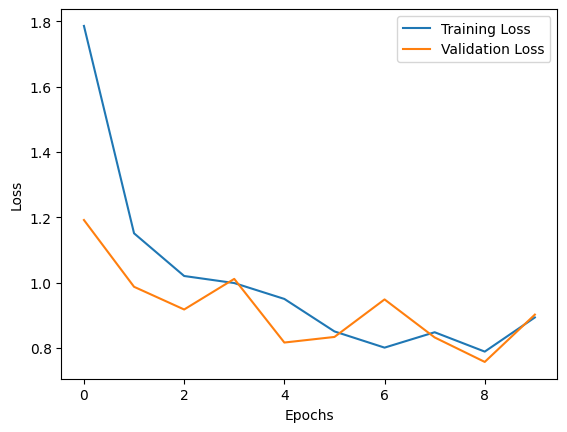

In [ ]:
print("Experiment B-2: add")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "add", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.795388, Val. Loss: 1.149683, F1: 0.614707
Epoch 2, Train Loss: 1.079612, Val. Loss: 0.825721, F1: 0.712185
Epoch 3, Train Loss: 0.842970, Val. Loss: 0.688044, F1: 0.752423
Epoch 4, Train Loss: 0.724989, Val. Loss: 0.618269, F1: 0.786089
Epoch 5, Train Loss: 0.664698, Val. Loss: 0.580632, F1: 0.794026
Epoch 6, Tr

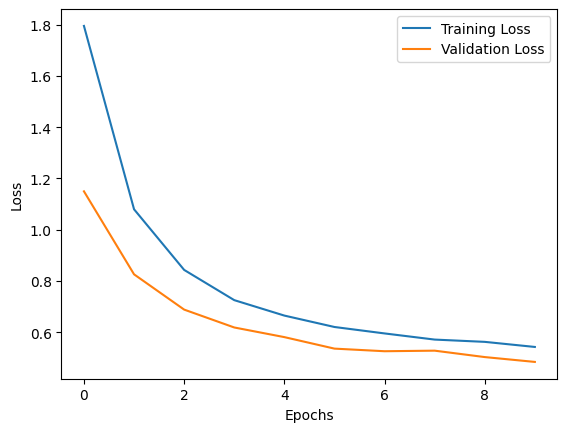

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.525728, Val. Loss: 0.684771, F1: 0.780271
Epoch 2, Train Loss: 0.772256, Val. Loss: 0.594577, F1: 0.806317
Epoch 3, Train Loss: 0.672122, Val. Loss: 0.547481, F1: 0.820907
Epoch 4, Train Loss: 0.628727, Val. Loss: 0.541204, F1: 0.821075
Epoch 5, Train Loss: 0.601972, Val. Loss: 0.523400, F1: 0.826482
Epoch 6, Tr

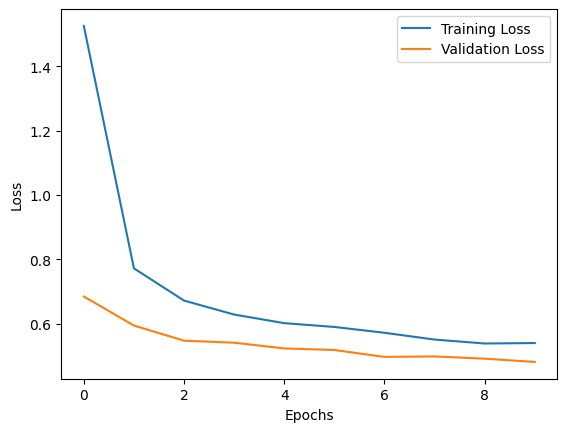

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: avg
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL average, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.966178, Val. Loss: 1.550730, F1: 0.413905
Epoch 2, Train Loss: 1.345778, Val. Loss: 1.063950, F1: 0.592098
Epoch 3, Train Loss: 1.098844, Val. Loss: 0.985402, F1: 0.673301
Epoch 4, Train Loss: 0.974136, Val. Loss: 0.833314, F1: 0.714287
Epoch 5, Train Loss: 0.852342, Val. Loss: 0.766229, F1: 0.733181
Epoch 6

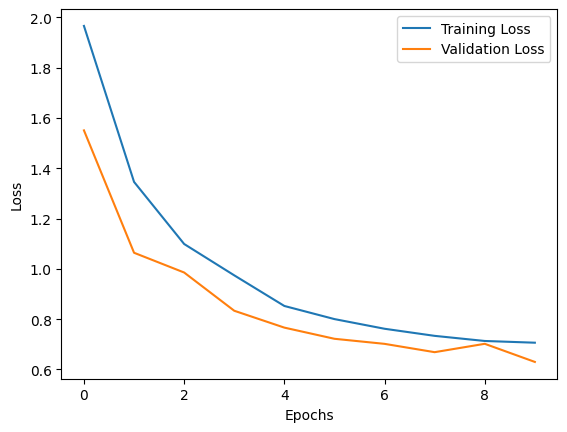

In [ ]:
print("Experiment B-3: avg")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "average", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.496216, Val. Loss: 0.686714, F1: 0.782016
Epoch 2, Train Loss: 0.760780, Val. Loss: 0.575676, F1: 0.812740
Epoch 3, Train Loss: 0.664277, Val. Loss: 0.536518, F1: 0.823180
Epoch 4, Train Loss: 0.616238, Val. Loss: 0.529785, F1: 0.827559
Epoch 5, Train Loss: 0.585071, Val. Loss: 0.503996, F1: 0.832405
Epoch 6, Tr

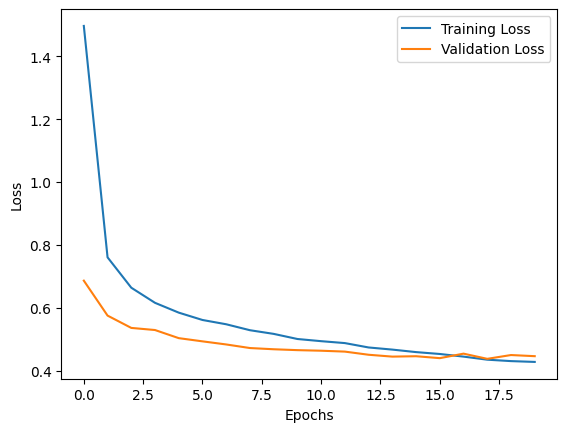

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.391988, Val. Loss: 0.682886, F1: 0.784335
Epoch 2, Train Loss: 0.744409, Val. Loss: 0.573694, F1: 0.816755
Epoch 3, Train Loss: 0.640409, Val. Loss: 0.530782, F1: 0.825501
Epoch 4, Train Loss: 0.601045, Val. Loss: 0.508328, F1: 0.831938
Epoch 5, Train Loss: 0.569778, Val. Loss: 0.493985, F1: 0.834373
Epoch 6, 

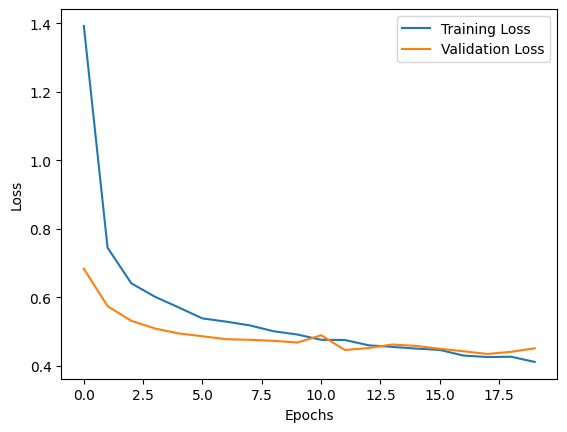

In [ ]:
print("Experiment B-3: sum")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.799362, Val. Loss: 1.063631, F1: 0.650091
Epoch 2, Train Loss: 0.944540, Val. Loss: 0.692818, F1: 0.759648
Epoch 3, Train Loss: 0.711204, Val. Loss: 0.583395, F1: 0.794483
Epoch 4, Train Loss: 0.628149, Val. Loss: 0.539197, F1: 0.812097
Epoch 5, Train Loss: 0.585219, Val. Loss: 0.513651, F1: 0.823280
Epoch 6, Tr

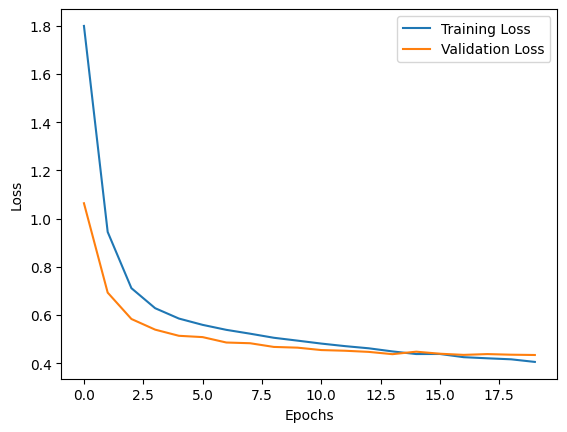

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment B-3: max
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL max, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.865308, Val. Loss: 1.275425, F1: 0.506610
Epoch 2, Train Loss: 1.072713, Val. Loss: 0.794882, F1: 0.726172
Epoch 3, Train Loss: 0.793821, Val. Loss: 0.647160, F1: 0.775092
Epoch 4, Train Loss: 0.675353, Val. Loss: 0.575733, F1: 0.800781
Epoch 5, Train Loss: 0.611660, Val. Loss: 0.527992, F1: 0.820956
Epoch 6, 

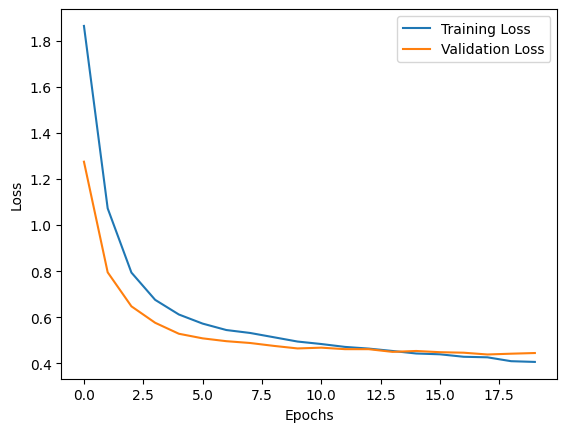

In [ ]:
print("Experiment B-3: max")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "max", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## C:  Hyper Parameter change

### C1: Bidirectional

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  352650
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.752014, Val. Loss: 1.269867, F1: 0.502485
Epoch 2, Train Loss: 1.232913, Val. Loss: 1.168120, F1: 0.540207
Epoch 3, Train Loss: 1.137012, Val. Loss: 1.322555, F1: 0.541918
Epoch 4, Train Loss: 1.382792, Val. Loss: 1.134661, F1: 0.571930
Epoch 5, Train Loss: 1.108487, Val. Loss: 

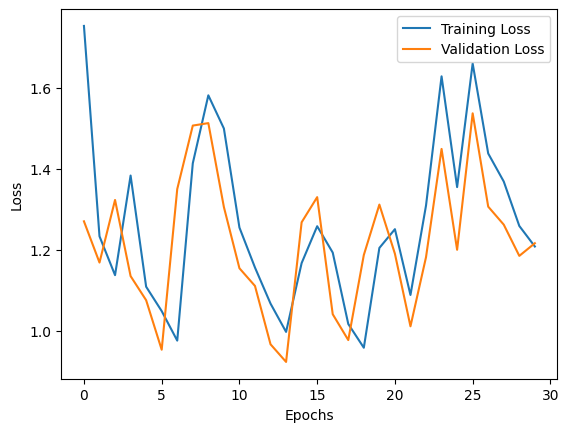

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 50, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  1209738
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.858730, Val. Loss: 1.206621, F1: 0.542801
Epoch 2, Train Loss: 1.077882, Val. Loss: 0.931175, F1: 0.661519
Epoch 3, Train Loss: 0.876443, Val. Loss: 0.739735, F1: 0.729469
Epoch 4, Train Loss: 0.764801, Val. Loss: 0.874967, F1: 0.724519
Epoch 5, Train Loss: 0.800018, Val. Lo

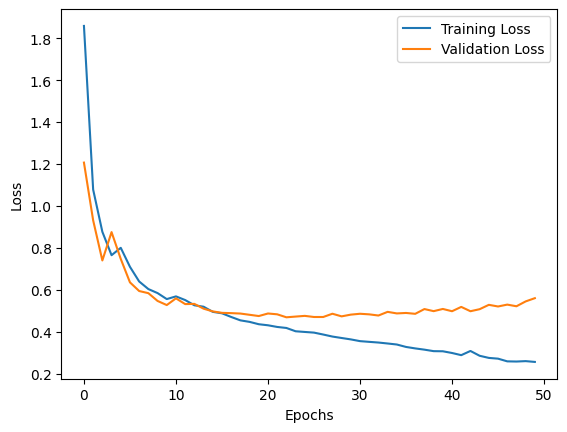

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs * 5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  924042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.745705, Val. Loss: 1.046300, F1: 0.578857
Epoch 2, Train Loss: 0.970367, Val. Loss: 0.754687, F1: 0.723009
Epoch 3, Train Loss: 0.752726, Val. Loss: 0.648085, F1: 0.759822
Epoch 4, Train Loss: 0.665152, Val. Loss: 0.585370, F1: 0.793223
Epoch 5, Train Loss: 0.612140, Val. Loss: 

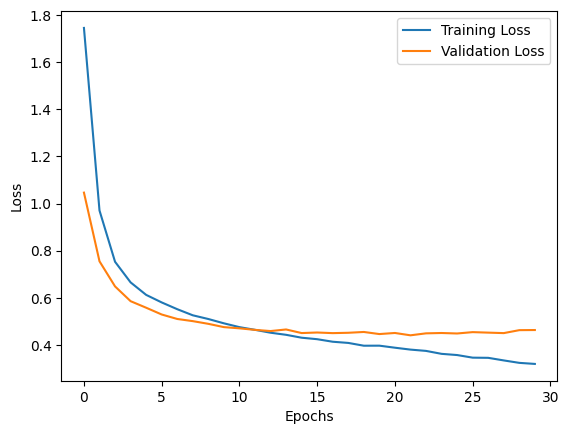

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs * 3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C2: Number of layers

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  308618
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.728437, Val. Loss: 1.166833, F1: 0.550242
Epoch 2, Train Loss: 1.203429, Val. Loss: 1.018401, F1: 0.618311
Epoch 3, Train Loss: 1.246725, Val. Loss: 1.445507, F1: 0.366163
Epoch 4, Train Loss: 1.439532, Val. Loss: 1.438879, F1: 0.469871
Epoch 5, Train Loss: 1.267583, Val. Loss: 1.020

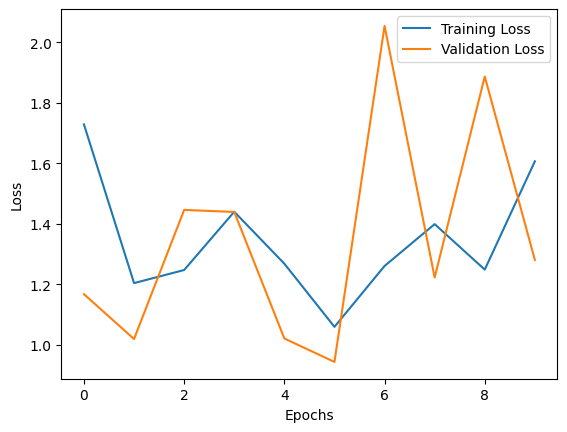

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  440202
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.659972, Val. Loss: 1.311024, F1: 0.488766
Epoch 2, Train Loss: 1.202242, Val. Loss: 1.058793, F1: 0.579593
Epoch 3, Train Loss: 1.242437, Val. Loss: 1.194890, F1: 0.523911
Epoch 4, Train Loss: 1.170559, Val. Loss: 1.000271, F1: 0.620790
Epoch 5, Train Loss: 0.998491, Val. Loss: 0.923

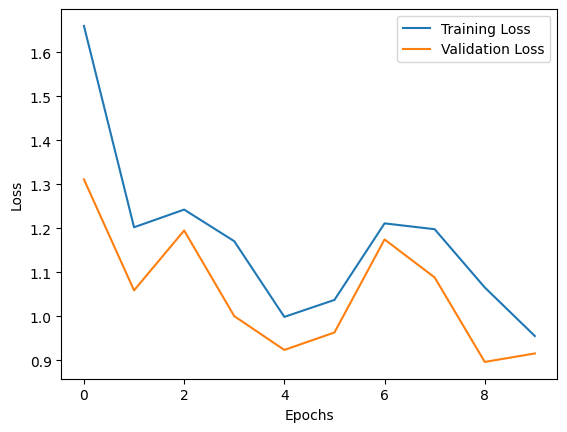

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  1197706
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.988375, Val. Loss: 1.498351, F1: 0.316012
Epoch 2, Train Loss: 1.417280, Val. Loss: 1.342204, F1: 0.372175
Epoch 3, Train Loss: 1.189757, Val. Loss: 1.034434, F1: 0.589158
Epoch 4, Train Loss: 1.023082, Val. Loss: 

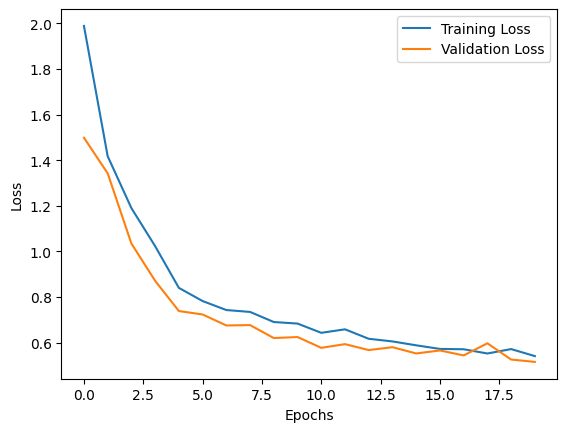

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  1724042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.929207, Val. Loss: 1.222575, F1: 0.475700
Epoch 2, Train Loss: 1.154831, Val. Loss: 0.903472, F1: 0.643982
Epoch 3, Train Loss: 0.923662, Val. Loss: 0.785136, F1: 0.712275
Epoch 4, Train Loss: 0.808750, Val. Loss: 

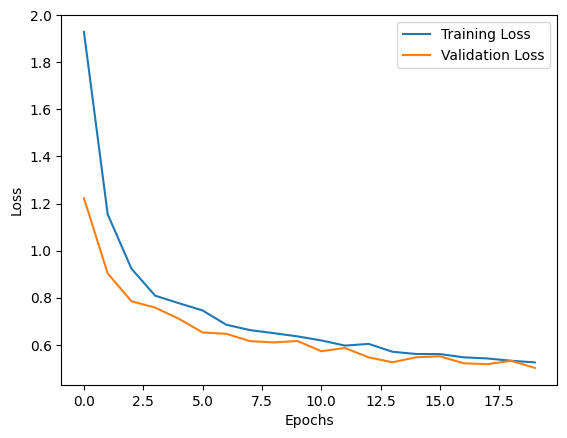

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: False
Trainable parameters:  923274
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.833326, Val. Loss: 1.133247, F1: 0.534162
Epoch 2, Train Loss: 1.045886, Val. Loss: 0.807936, F1: 0.677572
Epoch 3, Train Loss: 0.835969, Val. Loss: 0.696581, F1: 0.745908
Epoch 4, Train Loss: 0.711999, Val. Loss: 0.5

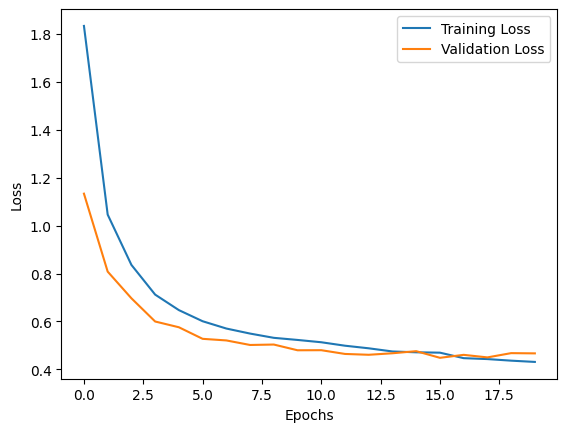

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 3, bidirectional: False
Trainable parameters:  1318026
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.859905, Val. Loss: 1.327544, F1: 0.355484
Epoch 2, Train Loss: 1.171243, Val. Loss: 0.930433, F1: 0.591263
Epoch 3, Train Loss: 0.903956, Val. Loss: 0.792157, F1: 0.695007
Epoch 4, Train Loss: 0.777791, Val. Loss: 0.

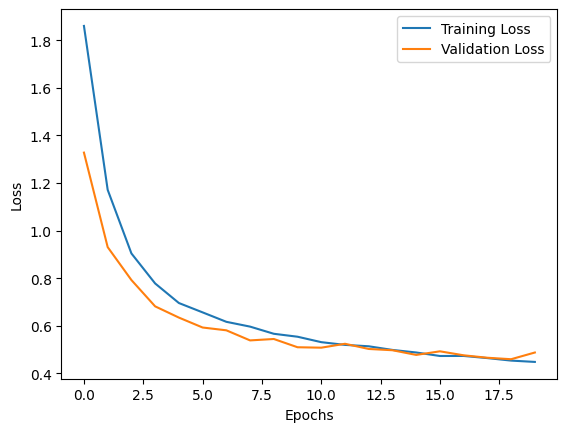

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=3, bidirectional= False, model_layer_map=[256, 128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C4 Learning Rate

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  462730
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.286609, Val. Loss: 2.262383, F1: 0.293516
Epoch 2, Train Loss: 2.224630, Val. Loss: 2.164978, F1: 0.355763
Epoch 3, Train Loss: 2.032447, Val. Loss: 1.836592, F1: 0.210836
Epoch 4, Train Loss: 1.727464, Val. Loss: 1.513679, F1: 0.496702
Epoch 5, Train Loss: 1.402946, Val. Loss: 1.181228, F1: 0.558901
Epoch 6, 

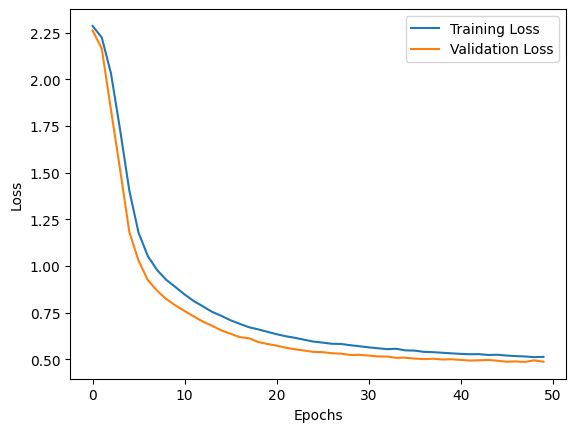

In [ ]:
print("Experiment C-4-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.293727, Val. Loss: 2.279645, F1: 0.168114
Epoch 2, Train Loss: 2.247861, Val. Loss: 2.179710, F1: 0.348812
Epoch 3, Train Loss: 1.964399, Val. Loss: 1.711110, F1: 0.398885
Epoch 4, Train Loss: 1.660449, Val. Loss: 1.480126, F1: 0.506369
Epoch 5, Train Loss: 1.408508, Val. Loss: 1.198803, F1: 0.563154
Epoch 

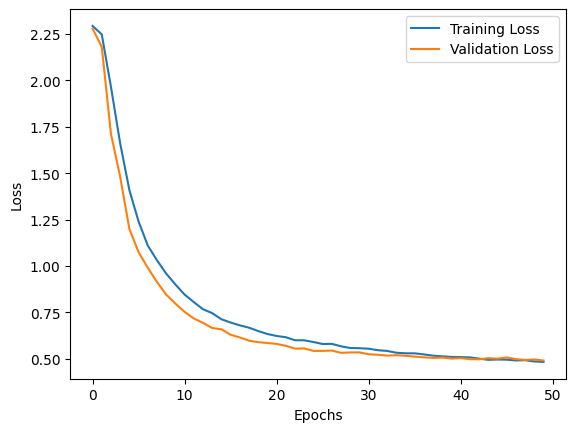

In [ ]:
print("Experiment C-4-2: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-2: RNN
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 50, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  177034
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.279485, Val. Loss: 2.238904, F1: 0.288757
Epoch 2, Train Loss: 2.094771, Val. Loss: 1.978618, F1: 0.126097
Epoch 3, Train Loss: 1.863898, Val. Loss: 1.732933, F1: 0.324891
Epoch 4, Train Loss: 1.668698, Val. Loss: 1.551954, F1: 0.341195
Epoch 5, Train Loss: 1.566674, Val. Loss: 1.455887, F1: 0.400169
Epoch 6, 

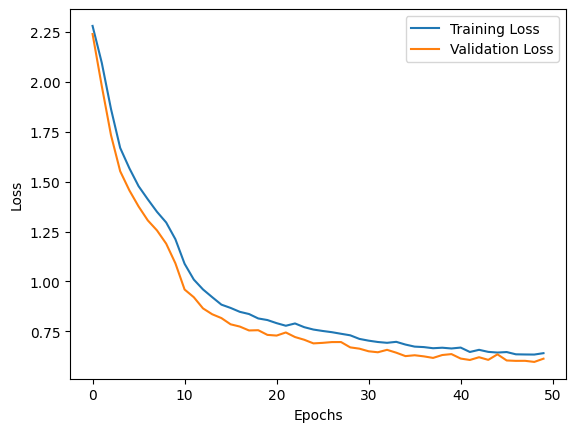

In [ ]:
print("Experiment C-4-3: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*5, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C5 Less hidden dimensions but more layers

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  105866
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.849513, Val. Loss: 1.408441, F1: 0.408081
Epoch 2, Train Loss: 1.359073, Val. Loss: 1.205379, F1: 0.511347
Epoch 3, Train Loss: 1.164773, Val. Loss: 1.056109, F1: 0.612534
Epoch 4, Train Loss: 1.057754, Val. Loss: 0.961591, F1: 0.648725
Epoch 5, Train Loss: 0.991688, Val. Loss: 0.997

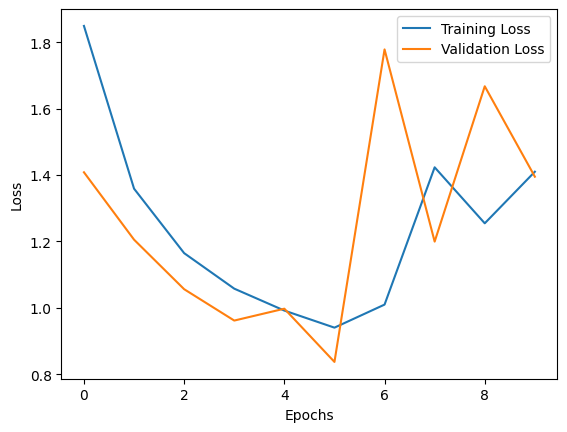

In [ ]:
print("Experiment C-5-1: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 10, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  57994
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.016208, Val. Loss: 1.586304, F1: 0.321077
Epoch 2, Train Loss: 1.479190, Val. Loss: 1.380971, F1: 0.380489
Epoch 3, Train Loss: 1.433732, Val. Loss: 1.501906, F1: 0.395110
Epoch 4, Train Loss: 1.516911, Val. Loss: 1.370536, F1: 0.439399
Epoch 5, Train Loss: 1.330733, Val. Loss: 1.203687,

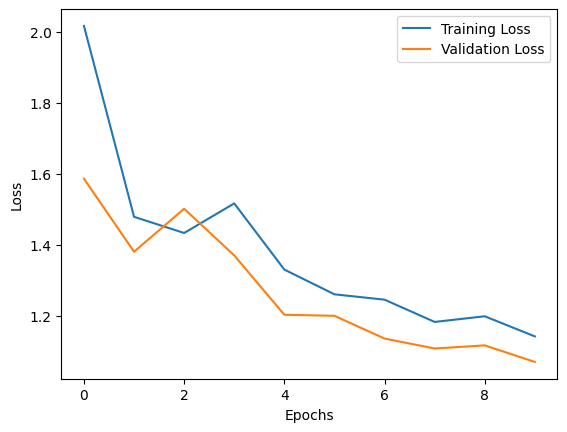

In [ ]:
print("Experiment C-5-2: RNN")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-3: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  281994
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.899698, Val. Loss: 1.297928, F1: 0.492630
Epoch 2, Train Loss: 1.082129, Val. Loss: 0.815345, F1: 0.692277
Epoch 3, Train Loss: 0.793787, Val. Loss: 0.662456, F1: 0.757448
Epoch 4, Train Loss: 0.683817, Val. Loss: 0.598816, F1: 0.784131
Epoch 5, Train Loss: 0.626874, Val. Loss: 0.559568, F1: 0.7

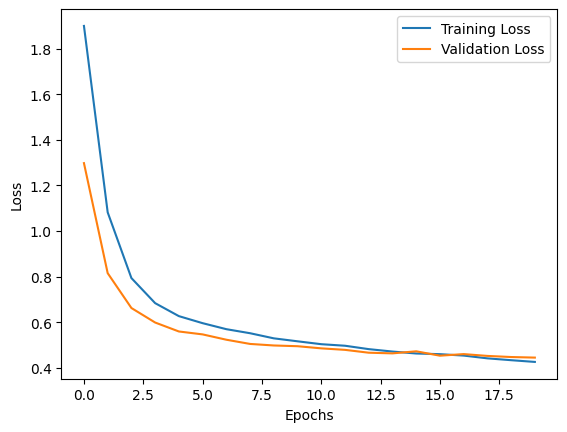

In [ ]:
print("Experiment C-5-3: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-4: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  154762
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.102928, Val. Loss: 1.583019, F1: 0.401734
Epoch 2, Train Loss: 1.289427, Val. Loss: 0.938348, F1: 0.647504
Epoch 3, Train Loss: 0.932297, Val. Loss: 0.782956, F1: 0.715745
Epoch 4, Train Loss: 0.795872, Val. Loss: 0.709964, F1: 0.750248
Epoch 5, Train Loss: 0.728007, Val. Loss: 0.658629, F1: 0.7669

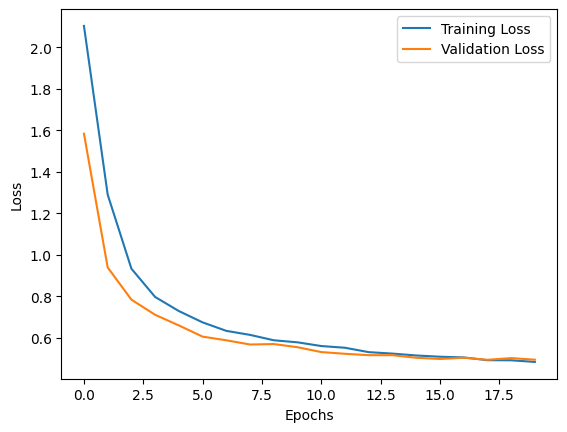

In [ ]:
print("Experiment C-5-4: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-5: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 128, num_layers: 2, bidirectional: False
Trainable parameters:  370058
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.975810, Val. Loss: 1.289712, F1: 0.488125
Epoch 2, Train Loss: 1.134083, Val. Loss: 0.903509, F1: 0.659890
Epoch 3, Train Loss: 0.922726, Val. Loss: 0.797652, F1: 0.708589
Epoch 4, Train Loss: 0.814705, Val. Loss: 0.722428, F1: 0.745420
Epoch 5, Train Loss: 0.751476, Val. Loss: 0.674976, F1: 

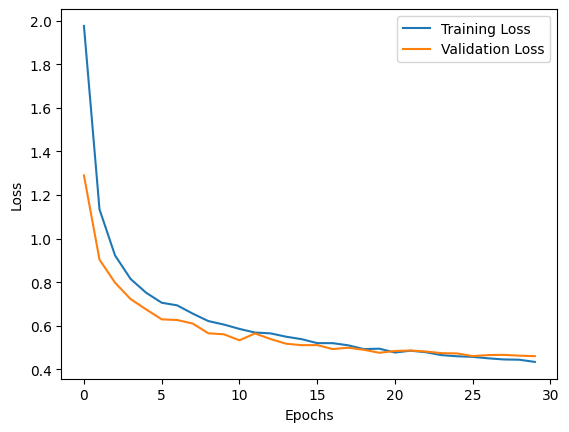

In [ ]:
print("Experiment C-5-5: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=int(hidden_dim/2), num_layers=2, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-5-6: LSTM
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 64, num_layers: 4, bidirectional: False
Trainable parameters:  203146
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 64, num_layers=4, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.229234, Val. Loss: 2.069836, F1: 0.067793
Epoch 2, Train Loss: 1.981186, Val. Loss: 1.795251, F1: 0.165969
Epoch 3, Train Loss: 1.630164, Val. Loss: 1.425210, F1: 0.356663
Epoch 4, Train Loss: 1.393107, Val. Loss: 1.336814, F1: 0.382546
Epoch 5, Train Loss: 1.271564, Val. Loss: 1.177410, F1: 0.4

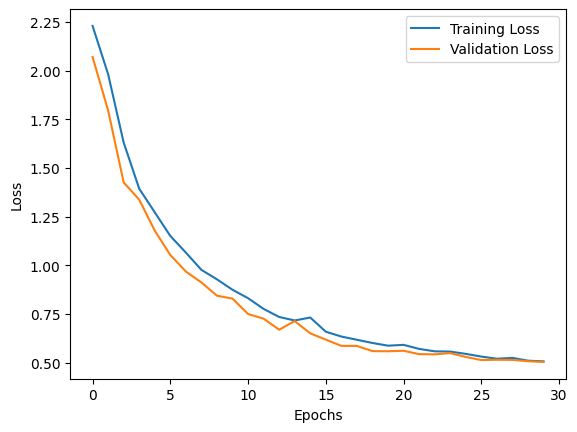

In [ ]:
print("Experiment C-5-6: LSTM")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=int(hidden_dim/4), num_layers=4, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C6 Bidirectional and reduced learning rate

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  352650
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.277030, Val. Loss: 2.234114, F1: 0.279890
Epoch 2, Train Loss: 2.115409, Val. Loss: 1.971804, F1: 0.277319
Epoch 3, Train Loss: 1.875249, Val. Loss: 1.725905, F1: 0.433904
Epoch 4, Train Loss: 1.597464, Val. Loss: 1.419540, F1: 0.469729
Epoch 5, Train Loss: 1.422419, Val. Loss:

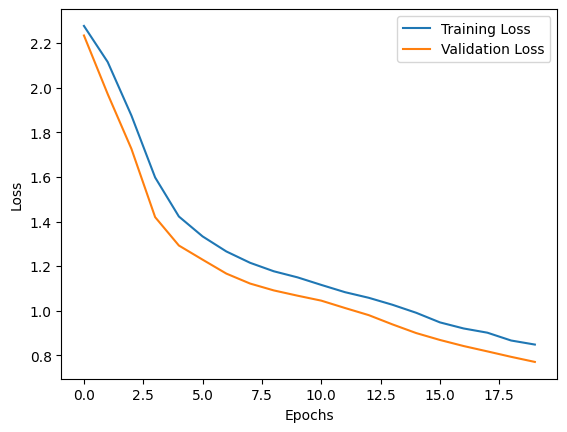

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  924042
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.285126, Val. Loss: 2.258268, F1: 0.259658
Epoch 2, Train Loss: 2.215667, Val. Loss: 2.148937, F1: 0.372248
Epoch 3, Train Loss: 1.994428, Val. Loss: 1.716731, F1: 0.361185
Epoch 4, Train Loss: 1.574399, Val. Loss: 1.349311, F1: 0.538886
Epoch 5, Train Loss: 1.315050, Val. Loss:

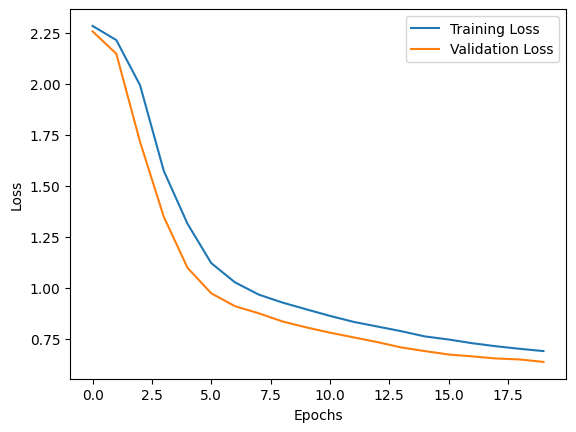

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: True
Trainable parameters:  1209738
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.293753, Val. Loss: 2.279069, F1: 0.142679
Epoch 2, Train Loss: 2.247867, Val. Loss: 2.183437, F1: 0.347159
Epoch 3, Train Loss: 1.953193, Val. Loss: 1.624476, F1: 0.421306
Epoch 4, Train Loss: 1.449499, Val. Loss: 1.211341, F1: 0.582329
Epoch 5, Train Loss: 1.217107, Val. L

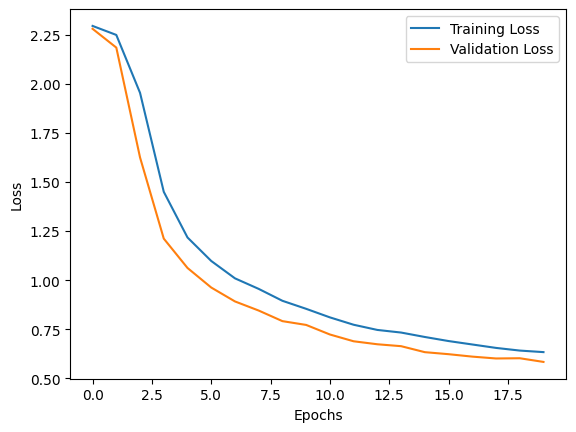

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C7 Bidirectional and higher layers with reduced learning rate

Experiment C-1: RNN Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: RNN, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  746890
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): RNN(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.239858, Val. Loss: 2.095406, F1: 0.343343
Epoch 2, Train Loss: 1.842494, Val. Loss: 1.568836, F1: 0.407557
Epoch 3, Train Loss: 1.516922, Val. Loss: 1.304643, F1: 0.515752
Epoch 4, Train Loss: 1.273292, Val. Loss: 1.094397, F1: 0.577540
Epoch 5, Train Loss: 1.1181

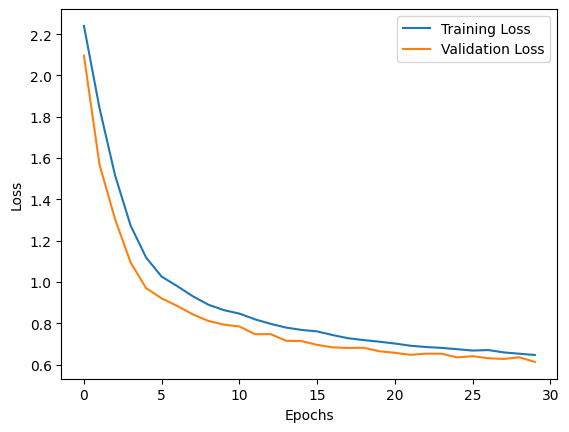

In [ ]:
print("Experiment C-1: RNN Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='RNN', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: GRU Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  2106762
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.272756, Val. Loss: 2.220472, F1: 0.384675
Epoch 2, Train Loss: 2.076113, Val. Loss: 1.809106, F1: 0.372619
Epoch 3, Train Loss: 1.601676, Val. Loss: 1.269456, F1: 0.550008
Epoch 4, Train Loss: 1.218812, Val. Loss: 0.994619, F1: 0.619009
Epoch 5, Train Loss: 1.030

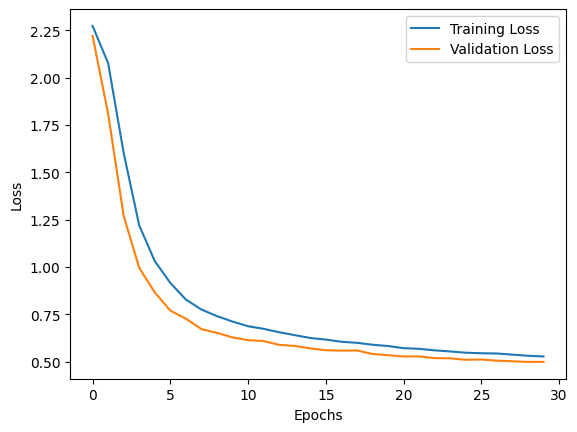

In [ ]:
print("Experiment C-1: GRU Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL last, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  2786698
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.295302, Val. Loss: 2.281656, F1: 0.165374
Epoch 2, Train Loss: 2.208279, Val. Loss: 1.953019, F1: 0.192078
Epoch 3, Train Loss: 1.582237, Val. Loss: 1.182225, F1: 0.559190
Epoch 4, Train Loss: 1.151479, Val. Loss: 0.934704, F1: 0.668751
Epoch 5, Train Loss: 0.

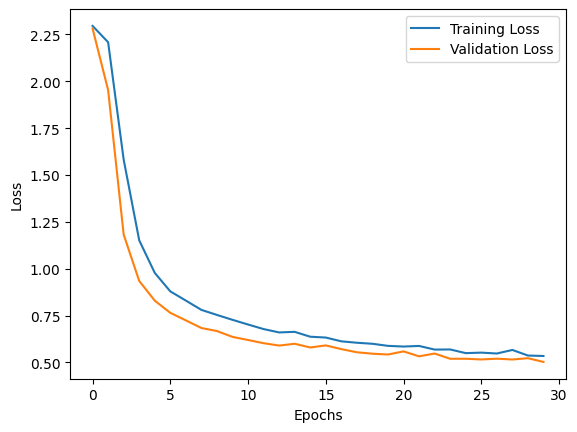

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "last", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### C8 Higher number of linear layers

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128, 64], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  470346
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.046586, Val. Loss: 1.460834, F1: 0.393085
Epoch 2, Train Loss: 1.279263, Val. Loss: 0.879275, F1: 0.633772
Epoch 3, Train Loss: 0.948117, Val. Loss: 0.744461, F1: 0.690212
Epoch 4, Train Loss: 0.832850, Val. Loss: 0.659484, F1: 0.754294
Epoch 5, Tr

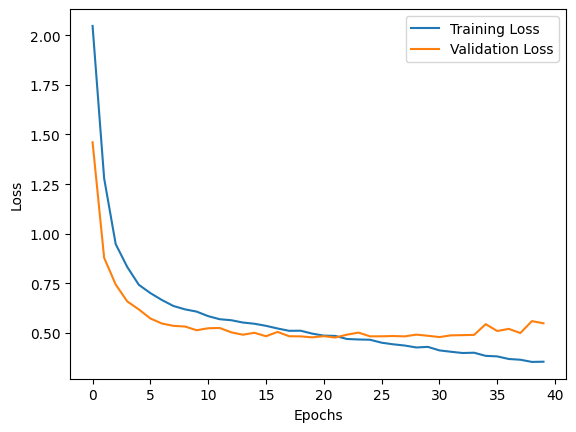

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128, 64, 32], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  472106
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=32, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.195263, Val. Loss: 1.790066, F1: 0.244750
Epoch 2, Train Loss: 1.696117, Val. Loss: 1.169631, F1: 0.533452
Epoch 3, Train Loss: 1.320720, Val. Loss: 0.920392, F1: 0.654899
Epoch 4, Tra

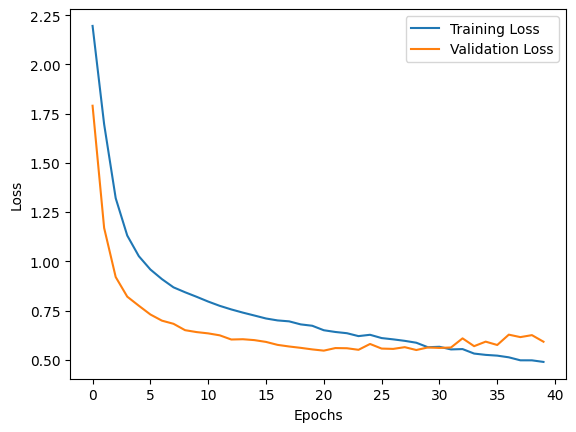

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128, 64, 32], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment A-1: GRU
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [256, 128, 64], lr: 0.001, epochs: 40, batch_size: 2048, RNN_type: GRU, fusion_typeL last, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  536138
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.086930, Val. Loss: 1.610756, F1: 0.337632
Epoch 2, Train Loss: 1.477934, Val. Loss: 1.048528, F1: 0.509907
Epoch 3, Train Loss: 1.066097, Val. Loss: 0.824196, F1: 0.646353
Epoch 4, 

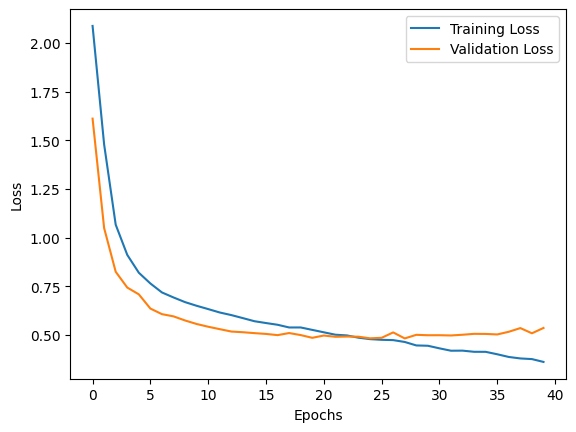

In [ ]:
print("Experiment A-1: GRU")
_, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*4, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='GRU', fusion_type = "last", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[256, 128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

### MIX

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: False, model_layer_map: [128, 64], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  48587814
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.193313, Val. Loss: 1.883700, F1: 0.452155
Epoch 2, Train Loss: 1.813840, Val. Loss: 1.344175, F1: 0.631451
Epoch 3, Train Loss: 1.450487, Val. Loss: 0.924709, F1: 0.755682
Epoch 4, Train Loss: 1.

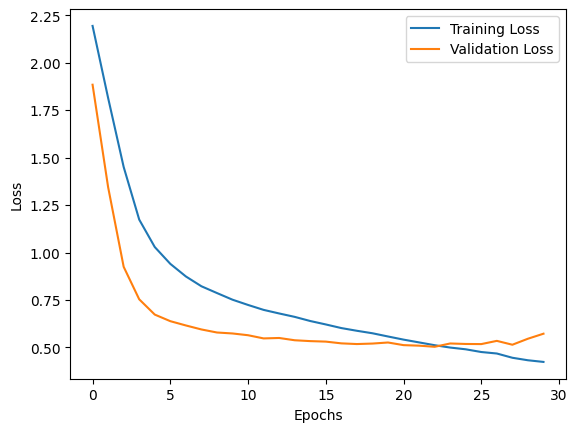

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=False,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Experiment C-1: LSTM Bidirectional
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: False, model_layer_map: [128, 64], lr: 0.0001, epochs: 30, batch_size: 2048, RNN_type: GRU, fusion_typeL sum, hidden_dim: 256, num_layers: 2, bidirectional: True
Trainable parameters:  47907878
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1, Train Loss: 2.165334, Val. Loss: 1.638250, F1: 0.606806
Epoch 2, Train Loss: 1.699664, Val. Loss: 1.216512, F1: 0.726987
Epoch 3, Train Loss: 1.450498, Val. Loss: 0.975705, F1: 0.772287
Epoch 4, Train Loss: 1.26

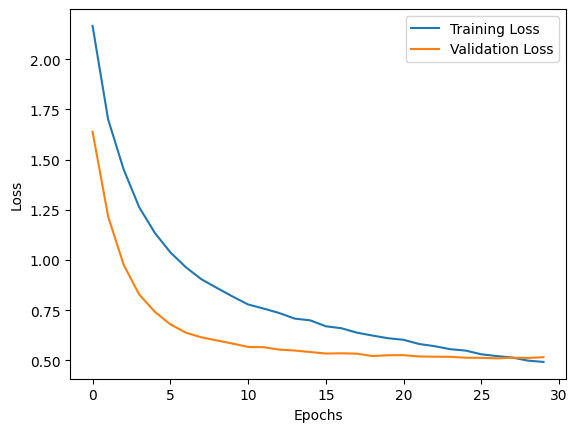

In [ ]:
print("Experiment C-1: LSTM Bidirectional")
_, train_loss, val_loss = train_evaluate(lr_=lr/10.0, epochs_=epochs*3, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=False,
                                         RNN_type='GRU', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=2, bidirectional= True, model_layer_map=[128, 64], verbose_=True)
plot_loss_curve(train_loss, val_loss)

## D: Best Model search

In [ ]:
# # Search and Save Best Model
# model_best, train_loss, val_loss = train_evaluate(lr_=0.001, epochs_=50, batch_size_=2048, hidden_dim=256, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
#                                          RNN_type='RNN', fusion_type = "last", num_layers=1, bidirectional= True, model_layer_map=[128], verbose_=True)
# plot_loss_curve(train_loss, val_loss)
# torch.save(model_best.to('cpu'), "best_model.bin")

Experiment B-3: sum
Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.227192, Val. Loss: 0.639582, F1: 0.797194
Epoch 2, Train Loss: 0.695165, Val. Loss: 0.552802, F1: 0.820665
Epoch 3, Train Loss: 0.616224, Val. Loss: 0.514949, F1: 0.828168
Epoch 4, Train Loss: 0.571240, Val. Loss: 0.498294, F1: 0.835725
Epoch 5, Train Loss: 0.557299, Val. Loss: 0.489553, F1: 0.836826
Epoch 6, 

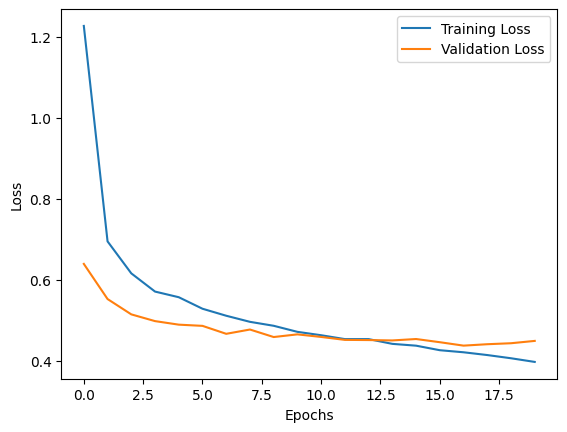

NameError: name 'model_best' is not defined

In [ ]:
print("Experiment B-3: sum")
model, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)
torch.save(model_best.to('cpu'), "best_model.bin")

In [ ]:
model, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)
model, train_loss, val_loss = train_evaluate(lr_=lr, epochs_=epochs*2, batch_size_=batch_size, embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                                         RNN_type='LSTM', fusion_type = "sum", hidden_dim=hidden_dim, num_layers=1, bidirectional= False, model_layer_map=[128], verbose_=True)
plot_loss_curve(train_loss, val_loss)

Model with embedding_type: custom_word2vec_300_5_5_20_1, oov_handler: zero, freeze_emb: True, model_layer_map: [128], lr: 0.001, epochs: 20, batch_size: 2048, RNN_type: LSTM, fusion_typeL sum, hidden_dim: 256, num_layers: 1, bidirectional: False
Trainable parameters:  605578
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (rnn): LSTM(300, 256, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1, Train Loss: 1.387068, Val. Loss: 0.663730, F1: 0.780575
